In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
import numpy as np


In [2]:

import torch.nn.functional as F


Features shape: torch.Size([100, 4])
Adjacency matrix shape: torch.Size([100, 100])
Epoch [1/100], Step [1/48], D Loss: 0.0012414270313456655, G Loss: 19.0377254486084
Epoch [1/100], Step [2/48], D Loss: 0.0011224175104871392, G Loss: 18.905324935913086
Epoch [1/100], Step [3/48], D Loss: 0.0009815230732783675, G Loss: 18.74891471862793
Epoch [1/100], Step [4/48], D Loss: 0.0008604608592577279, G Loss: 18.61328887939453
Epoch [1/100], Step [5/48], D Loss: 0.0007697667460888624, G Loss: 18.46089744567871
Epoch [1/100], Step [6/48], D Loss: 0.0006691963644698262, G Loss: 18.32164192199707
Epoch [1/100], Step [7/48], D Loss: 0.0005923574790358543, G Loss: 18.167200088500977
Epoch [1/100], Step [8/48], D Loss: 0.0005236672586761415, G Loss: 18.014999389648438
Epoch [1/100], Step [9/48], D Loss: 0.0004565893905237317, G Loss: 17.84775733947754
Epoch [1/100], Step [10/48], D Loss: 0.00039433021447621286, G Loss: 17.682727813720703
Epoch [1/100], Step [11/48], D Loss: 0.0003430621582083404, G

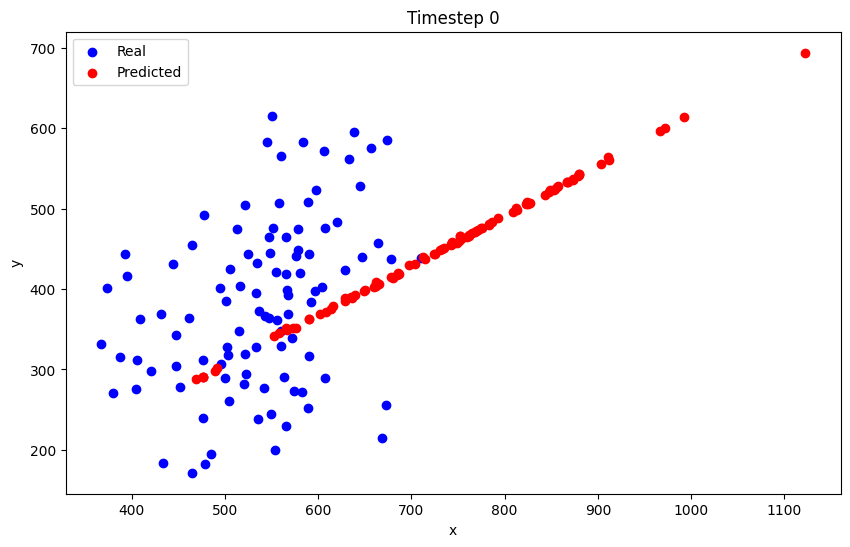

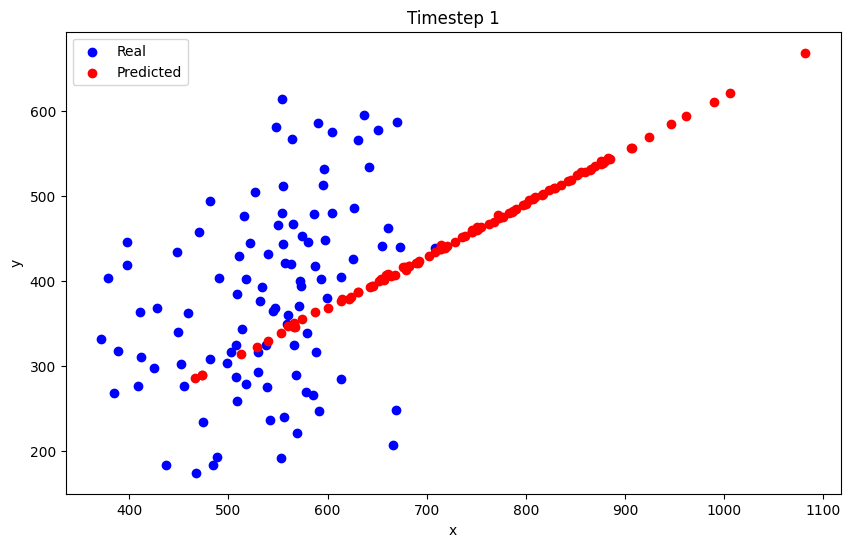

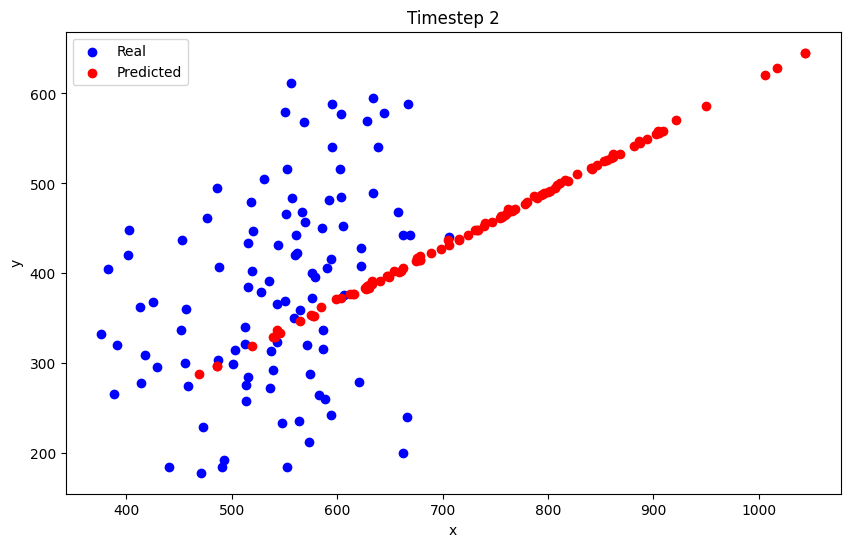

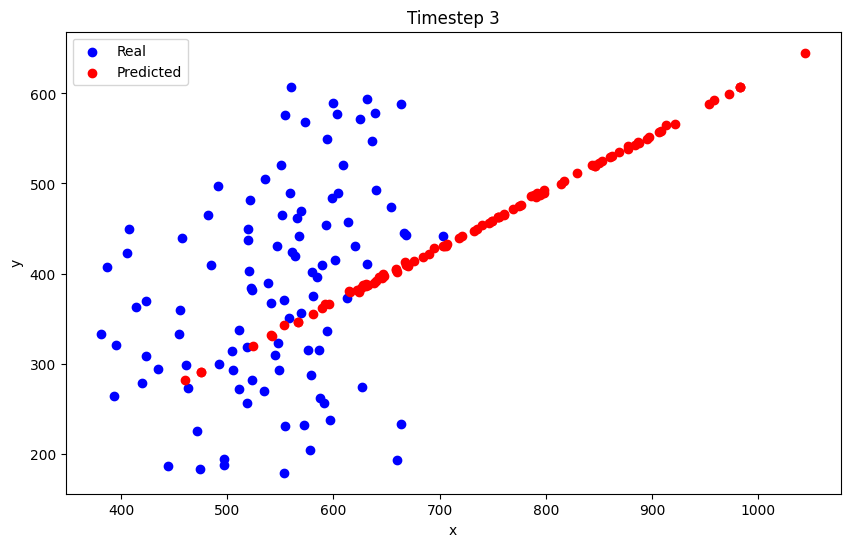

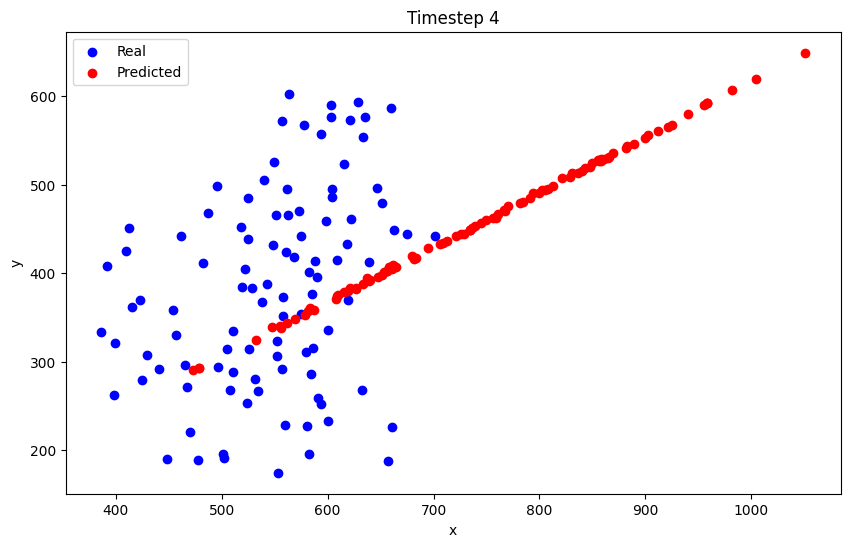

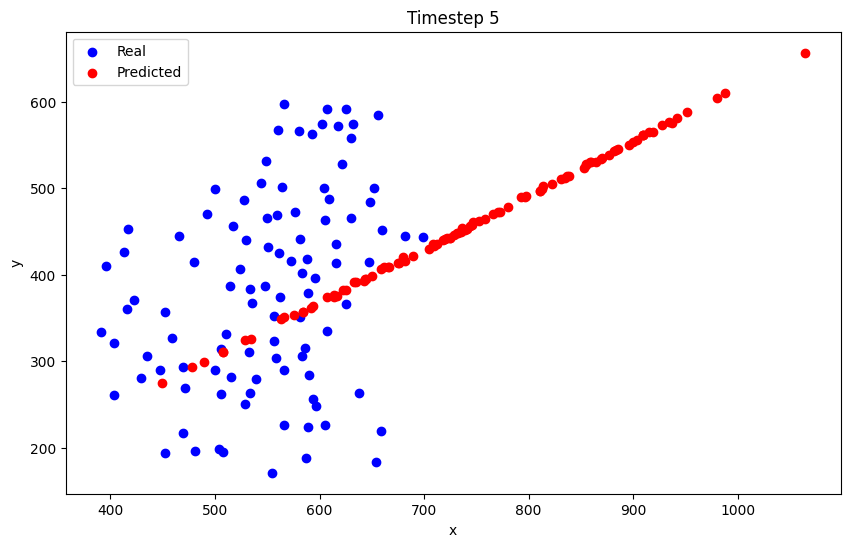

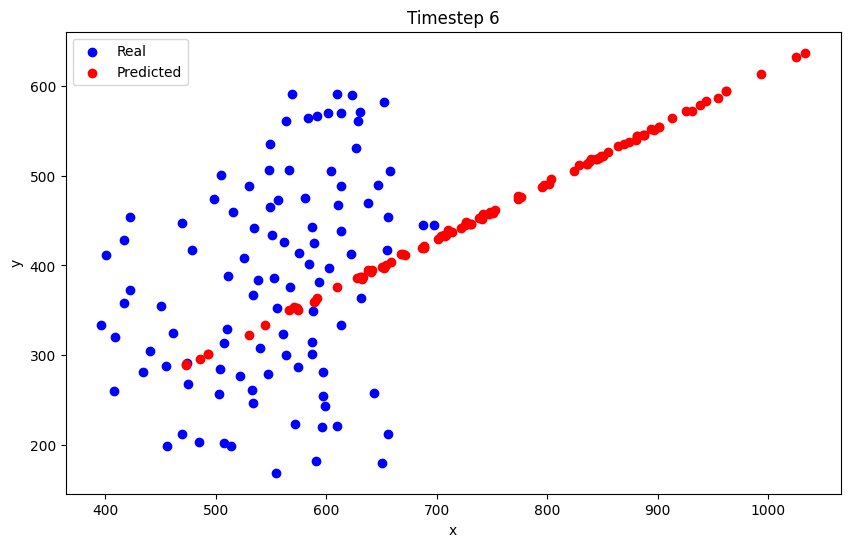

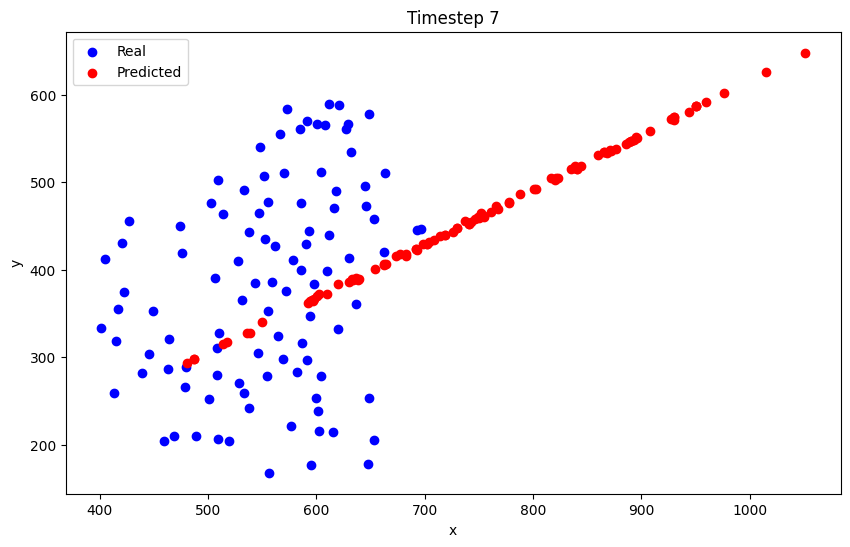

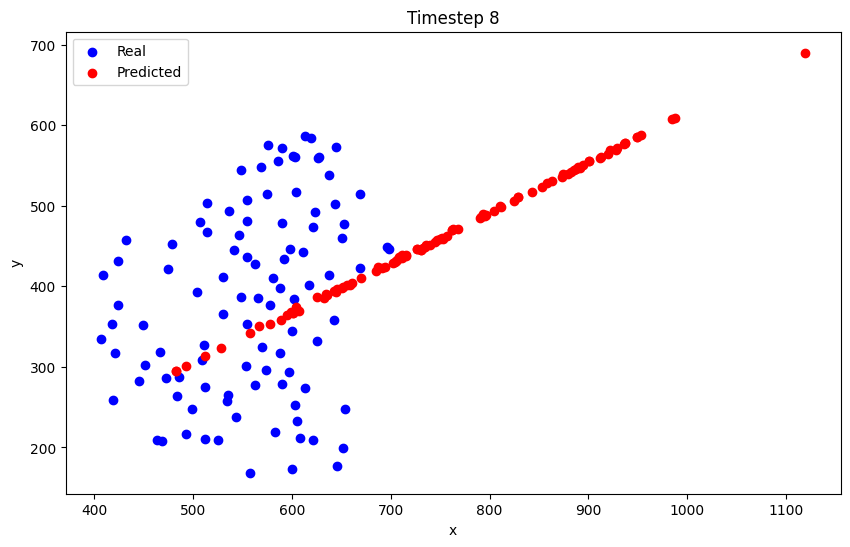

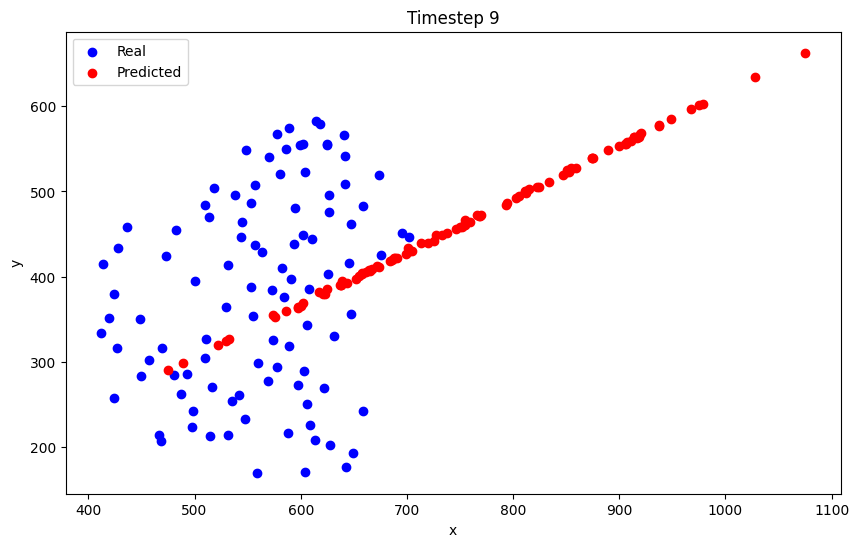

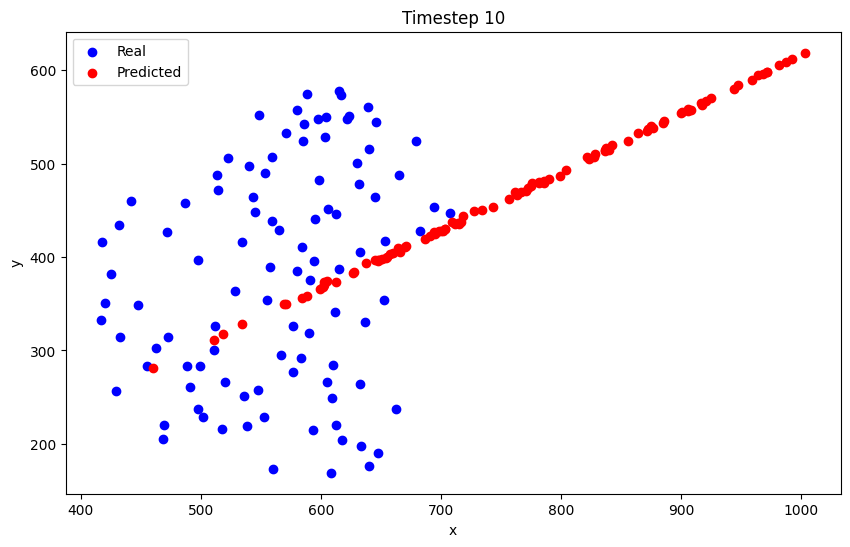

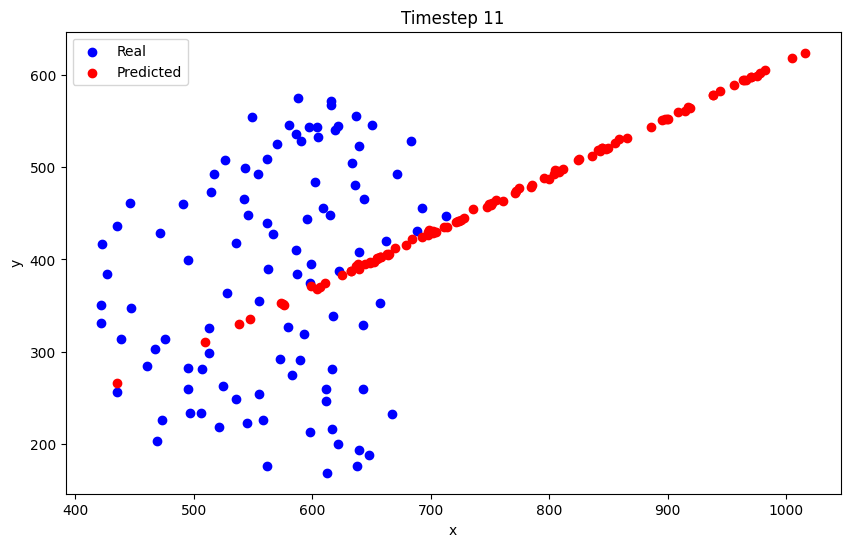

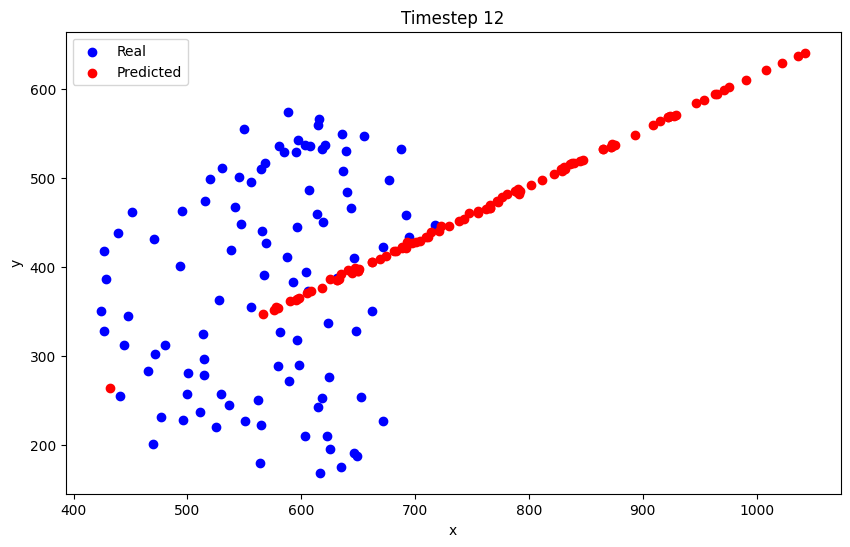

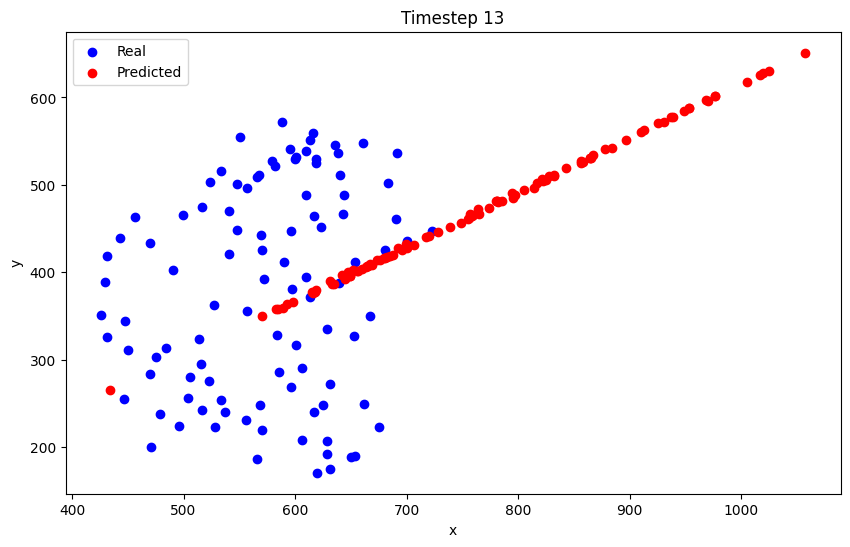

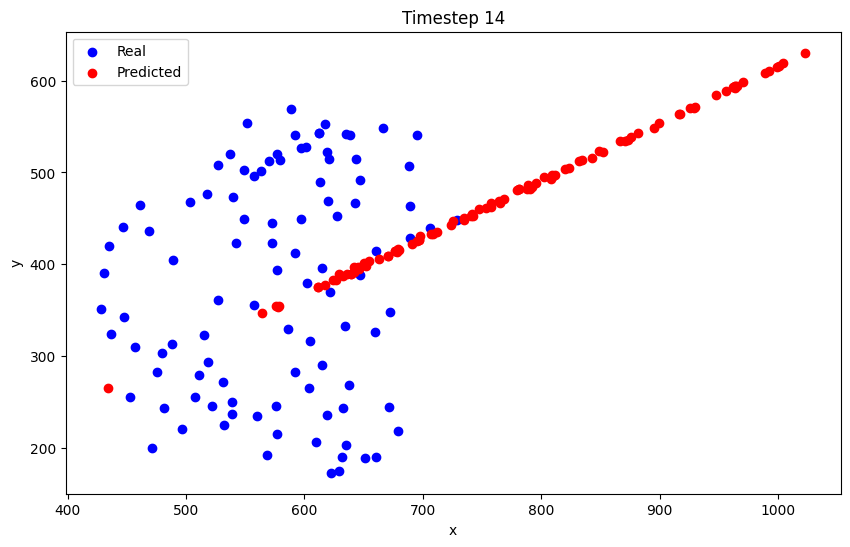

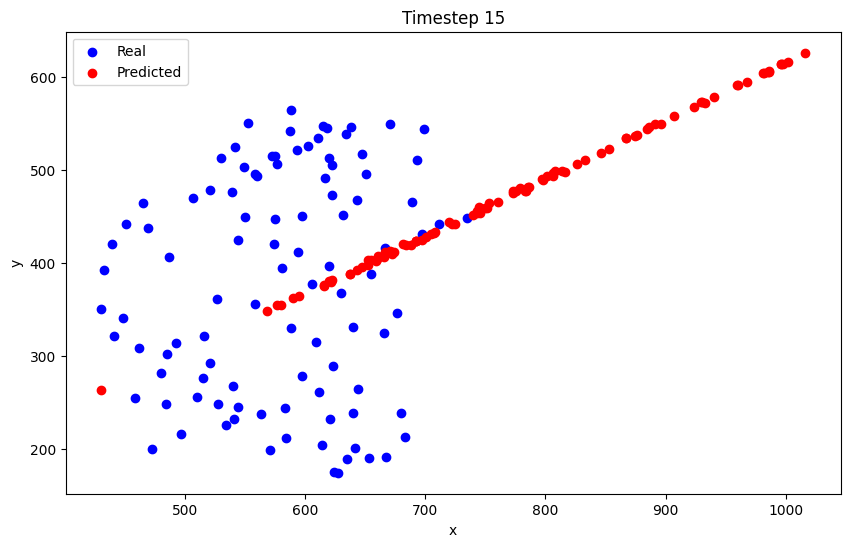

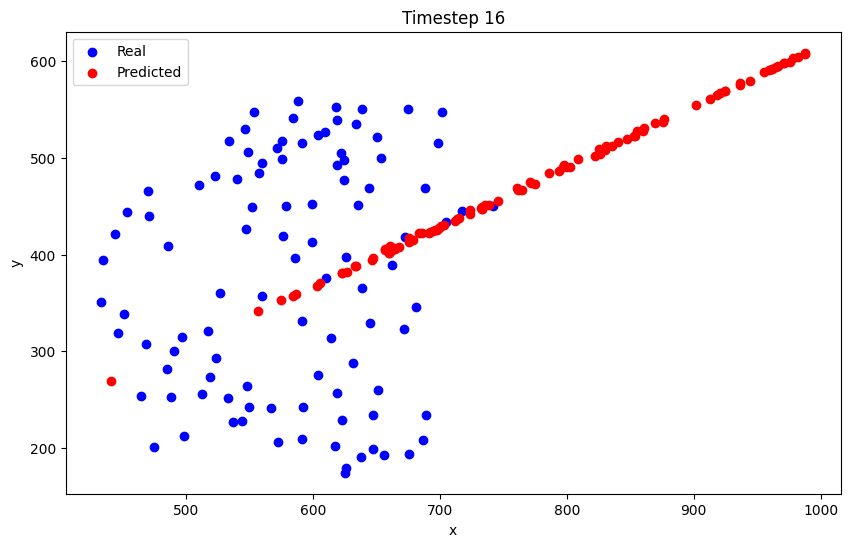

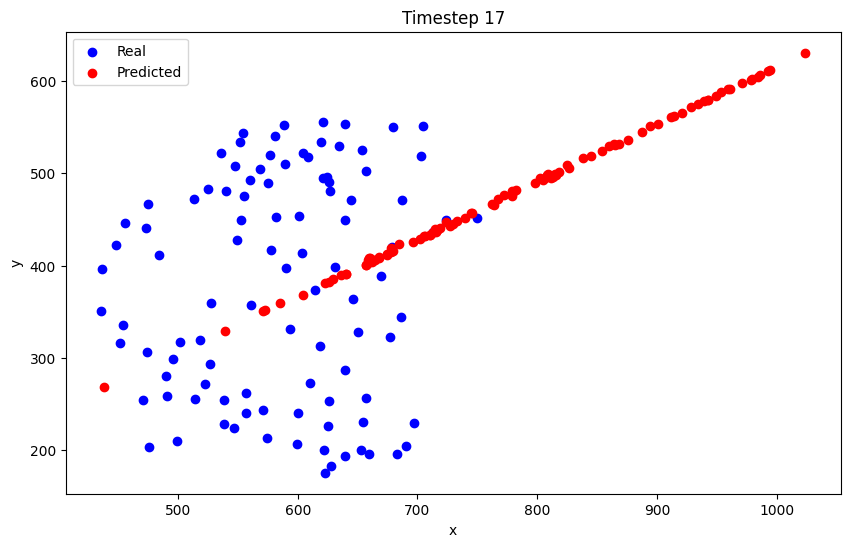

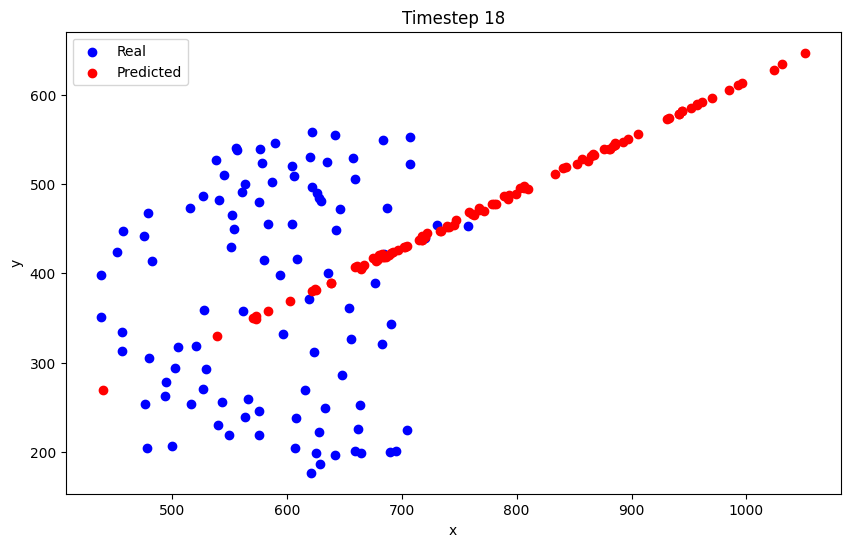

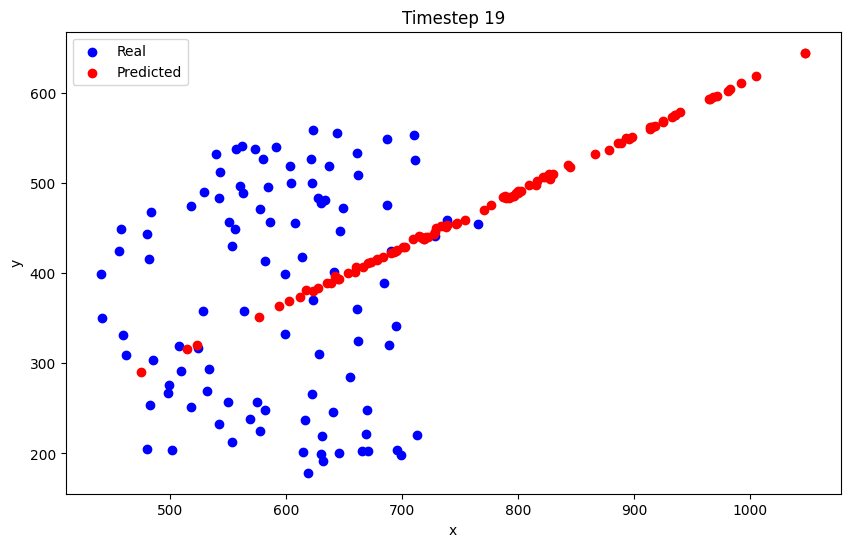

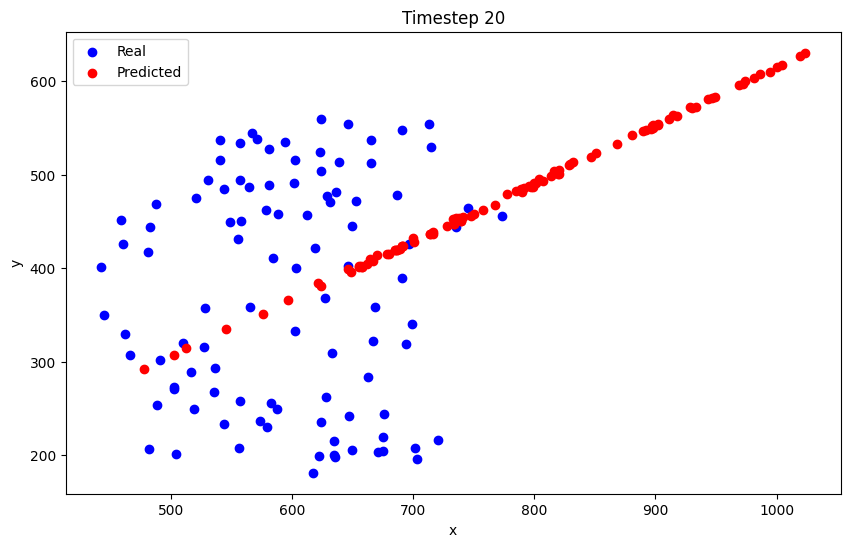

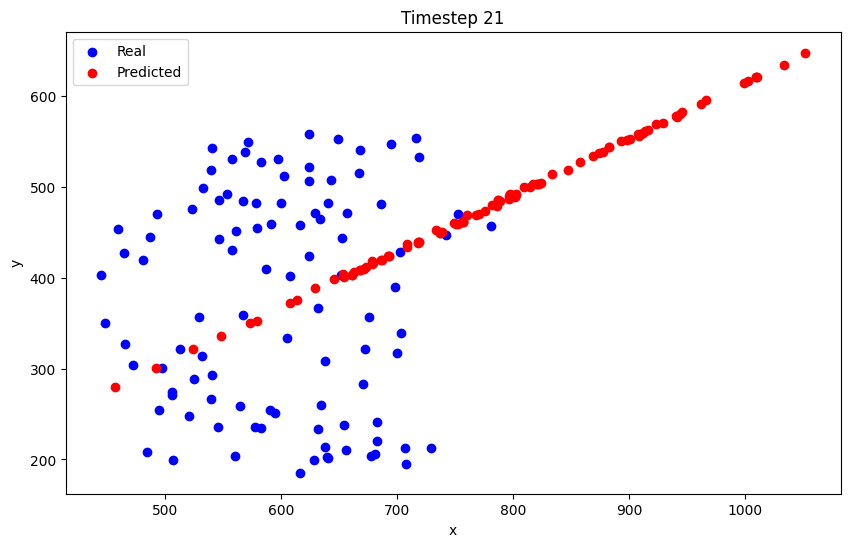

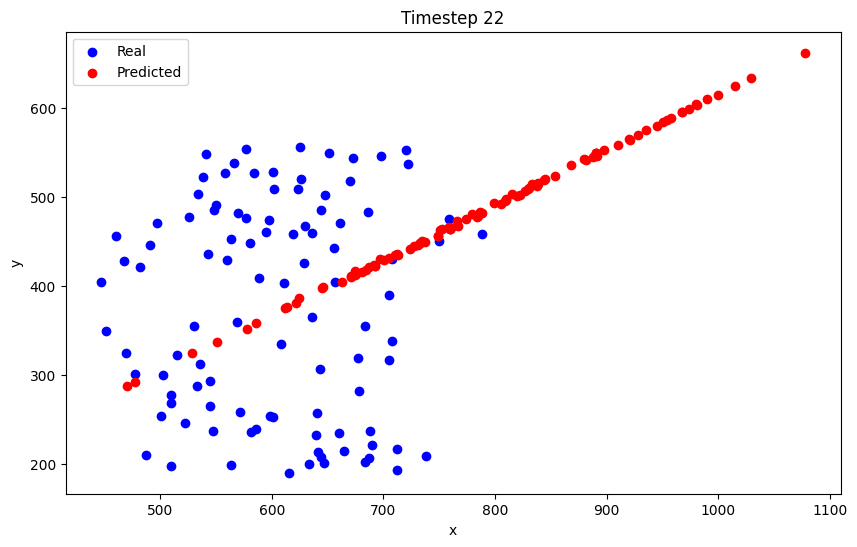

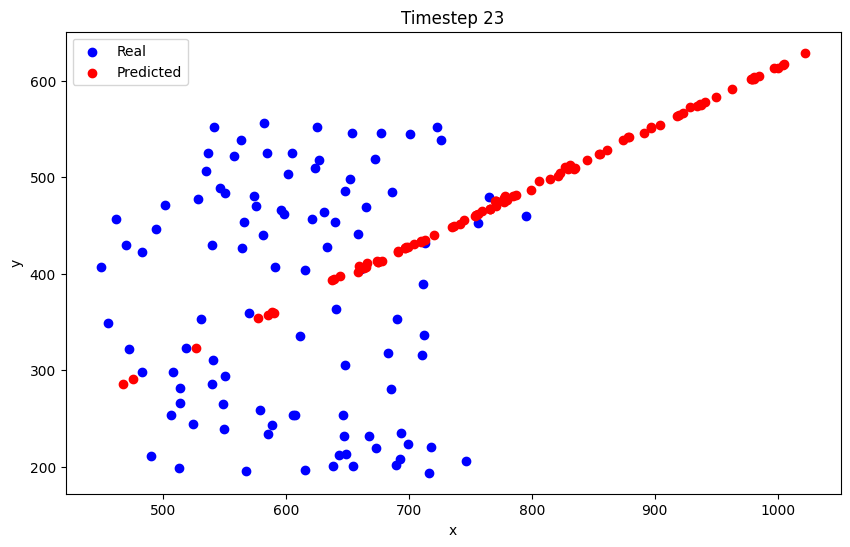

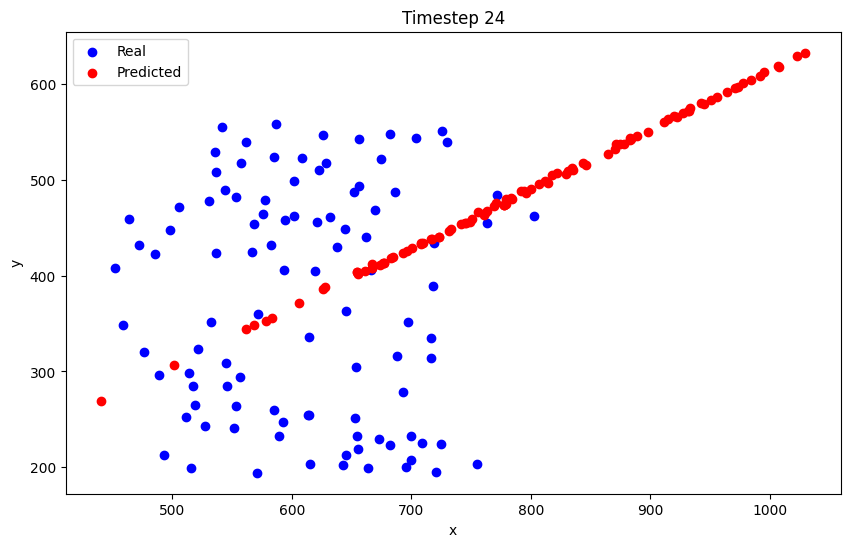

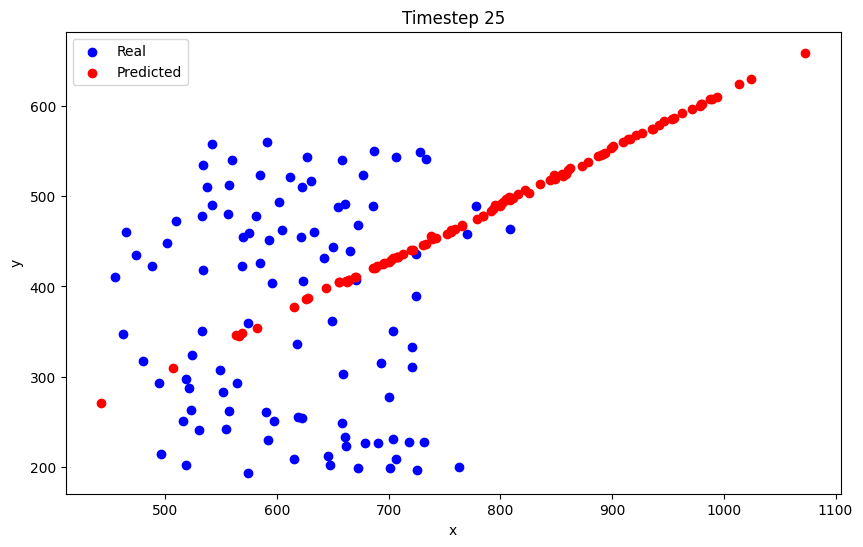

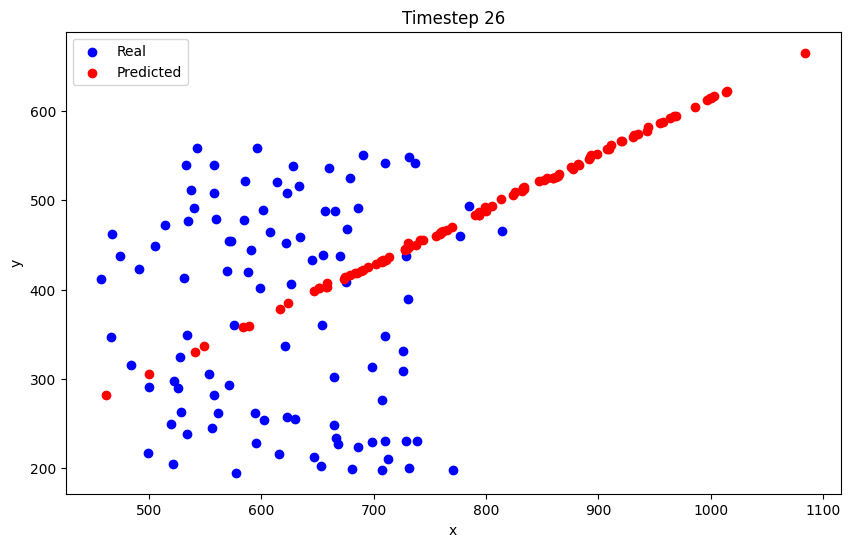

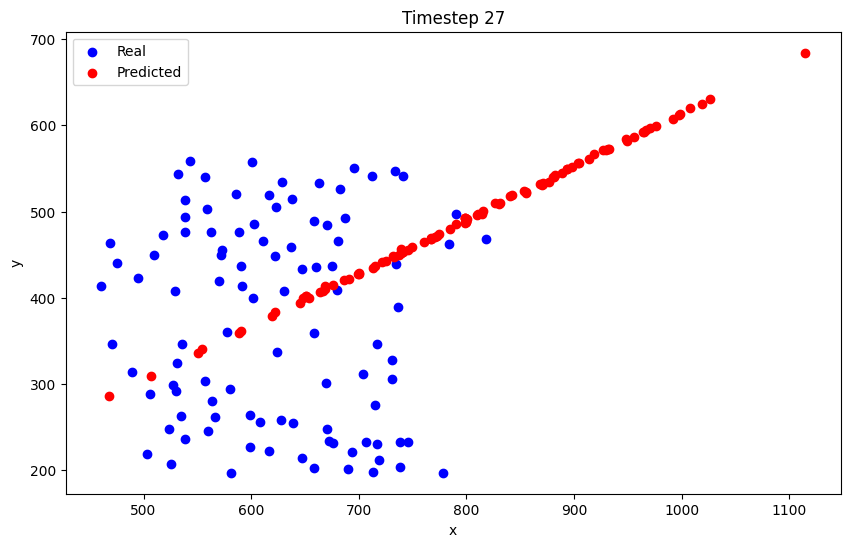

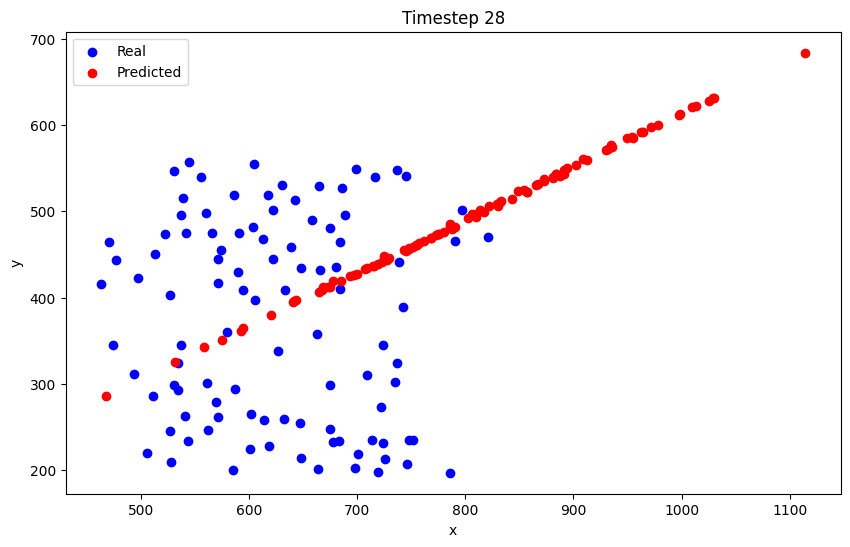

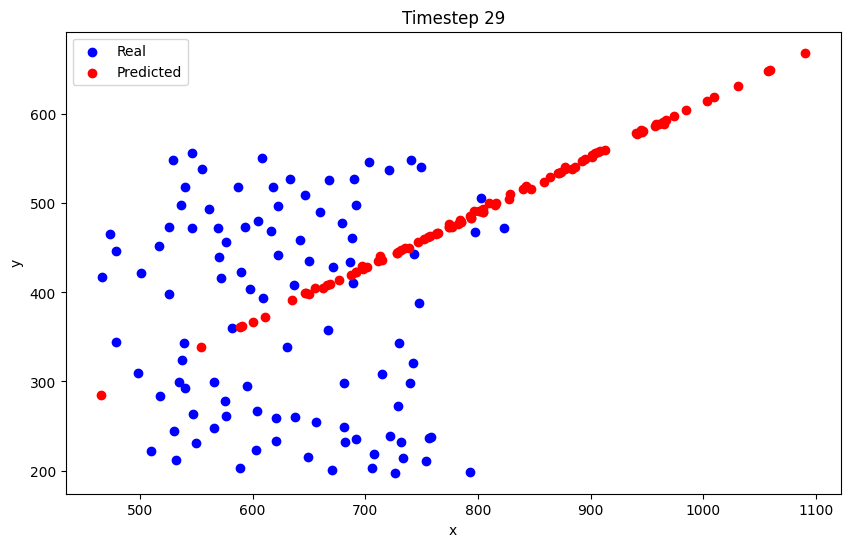

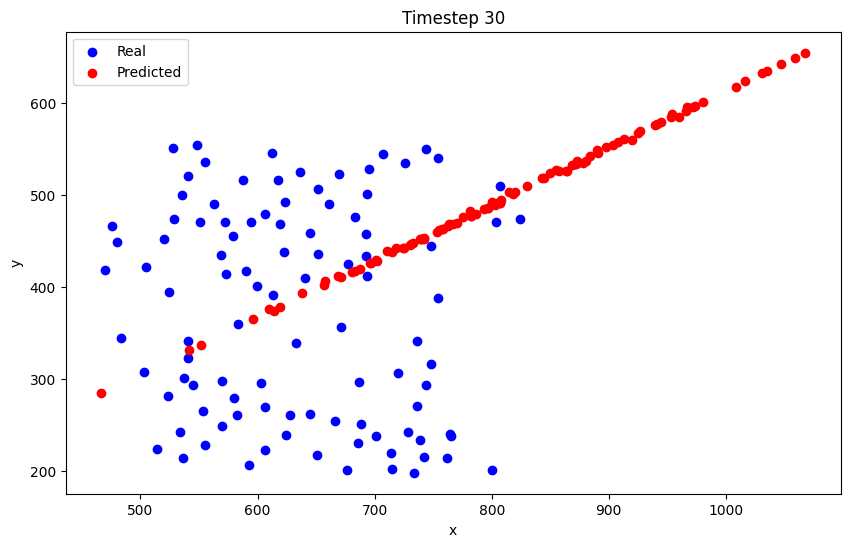

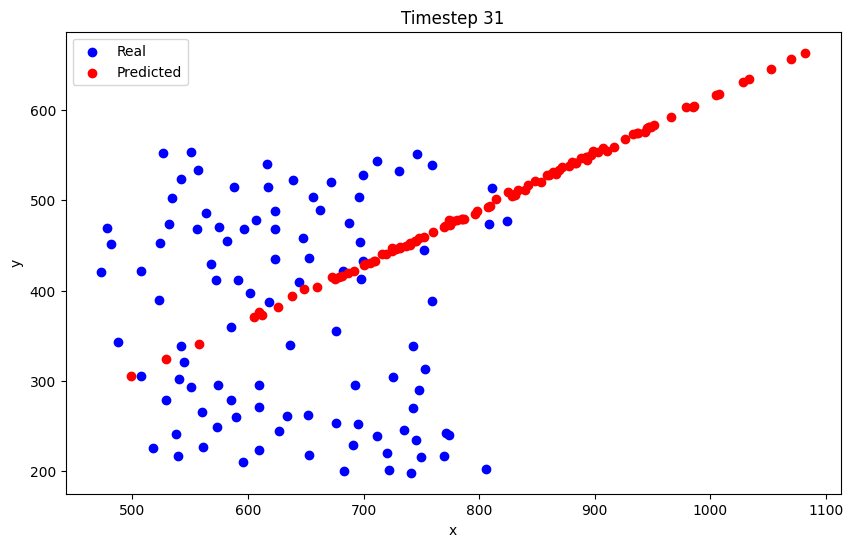

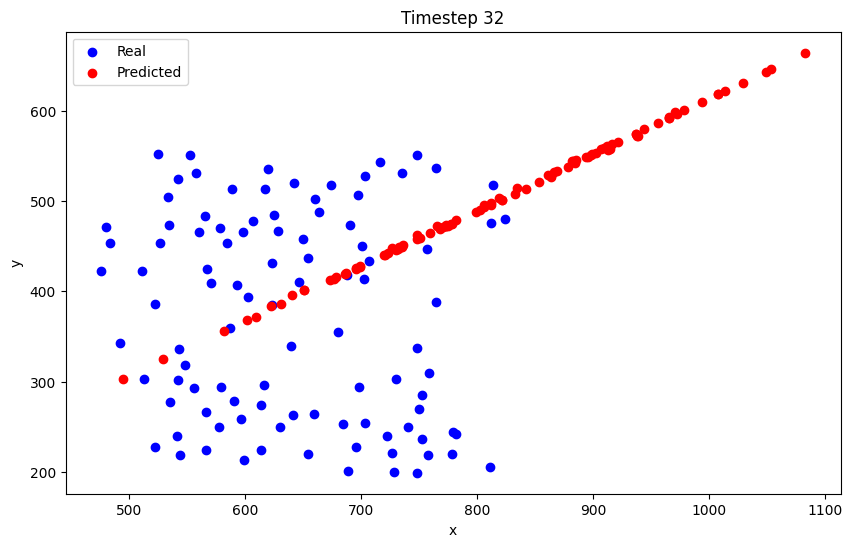

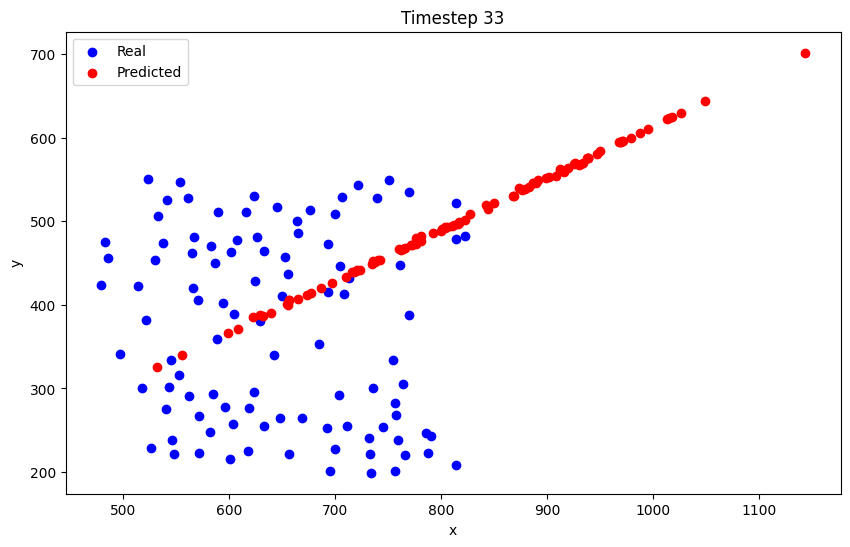

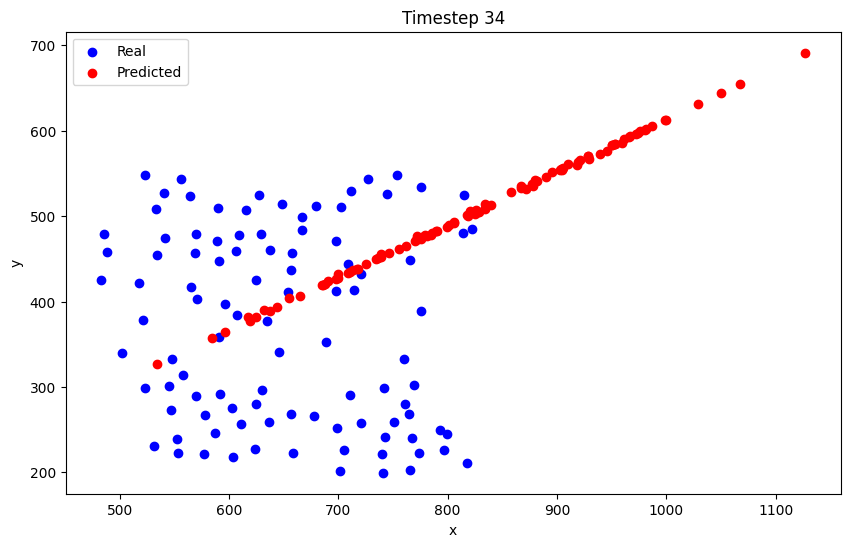

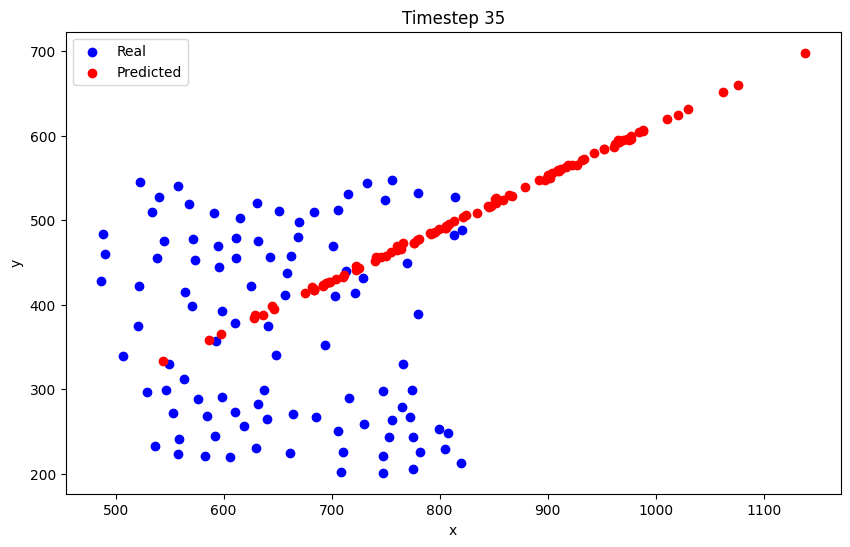

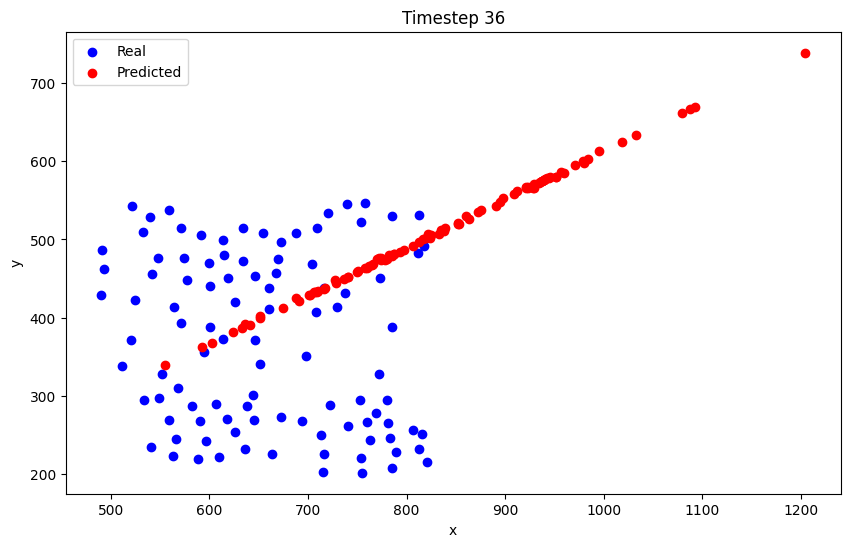

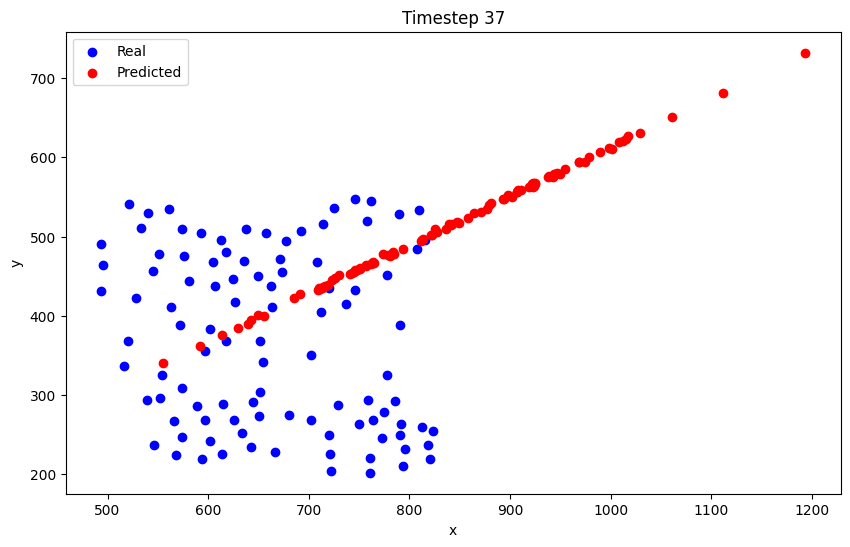

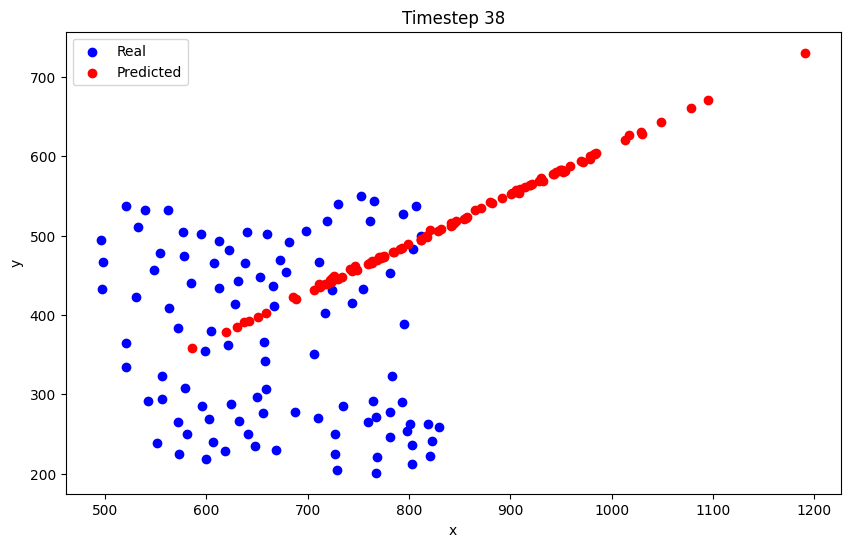

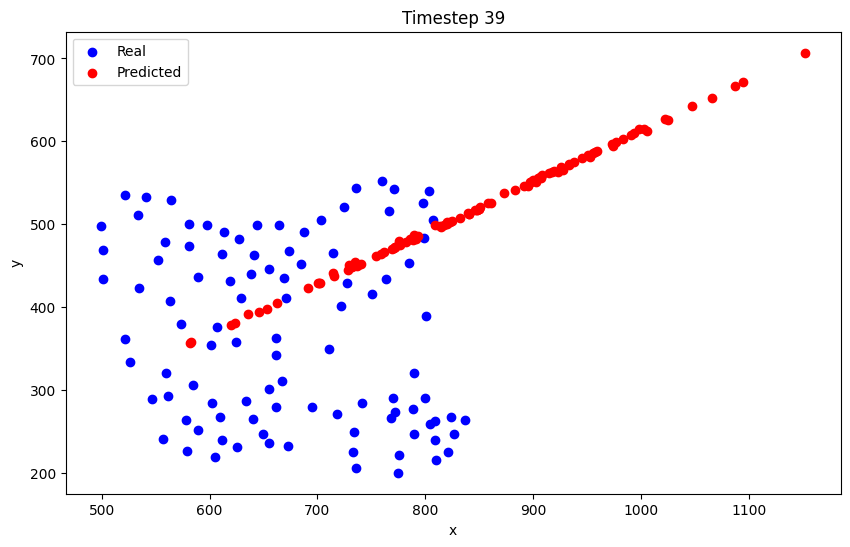

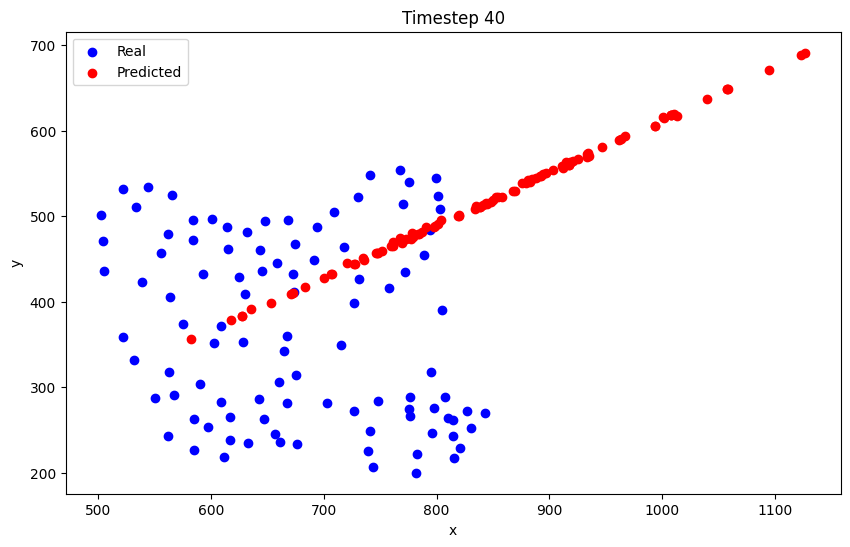

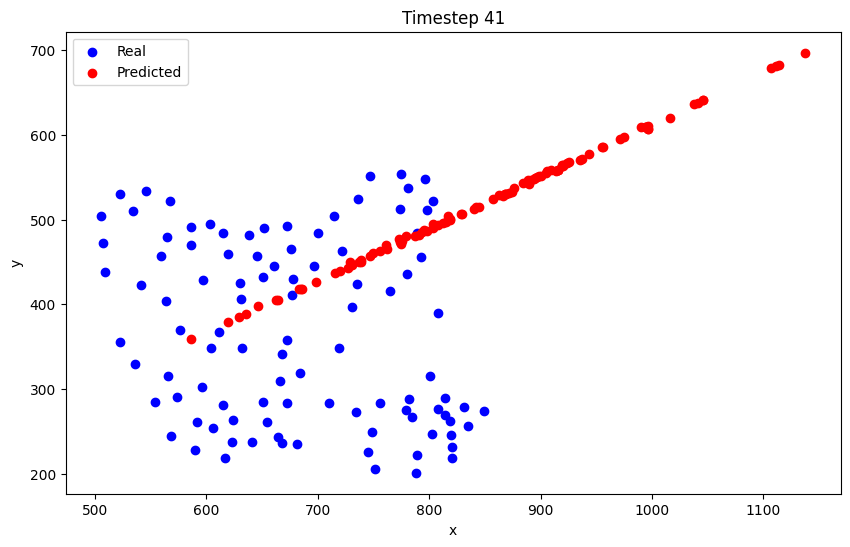

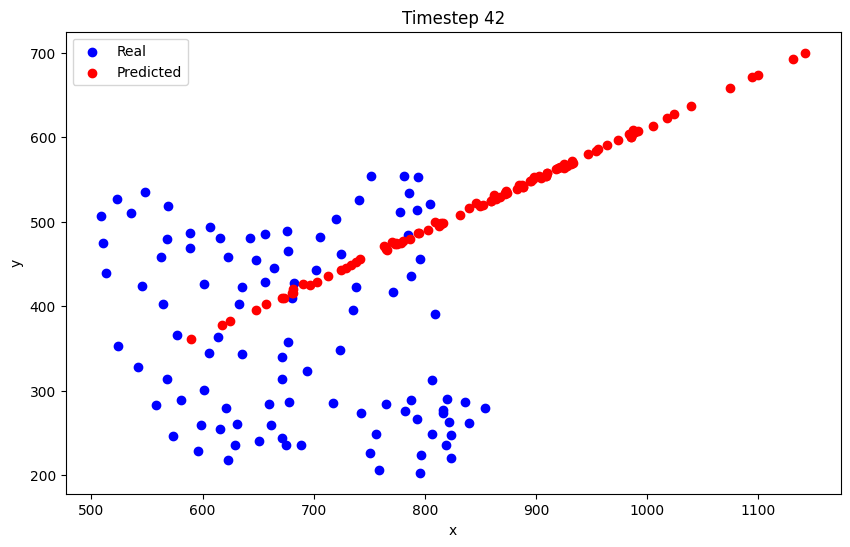

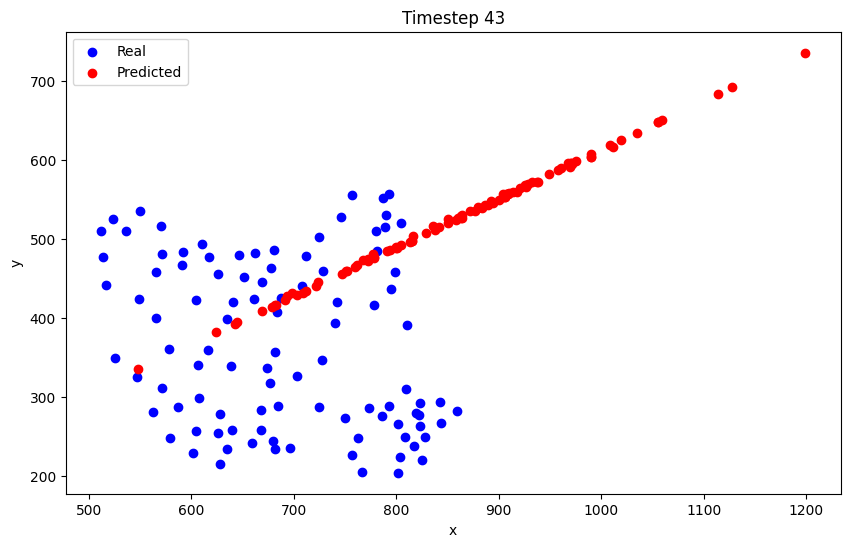

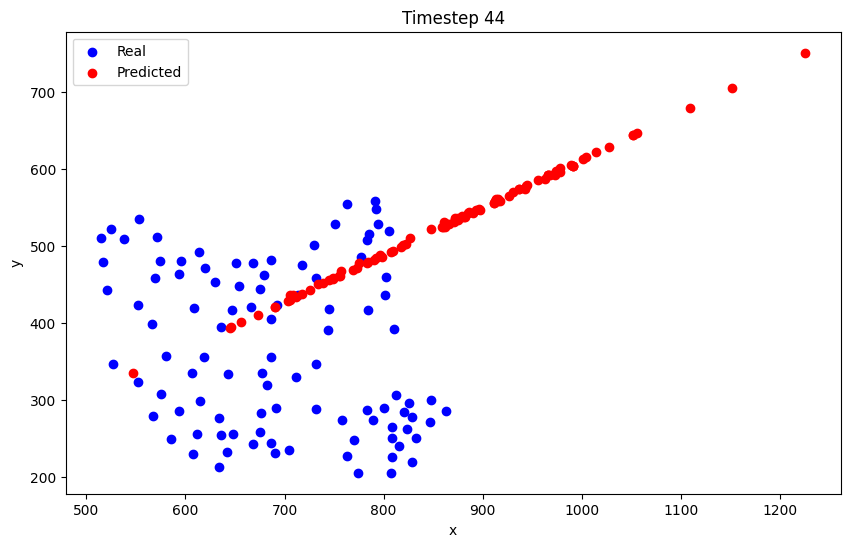

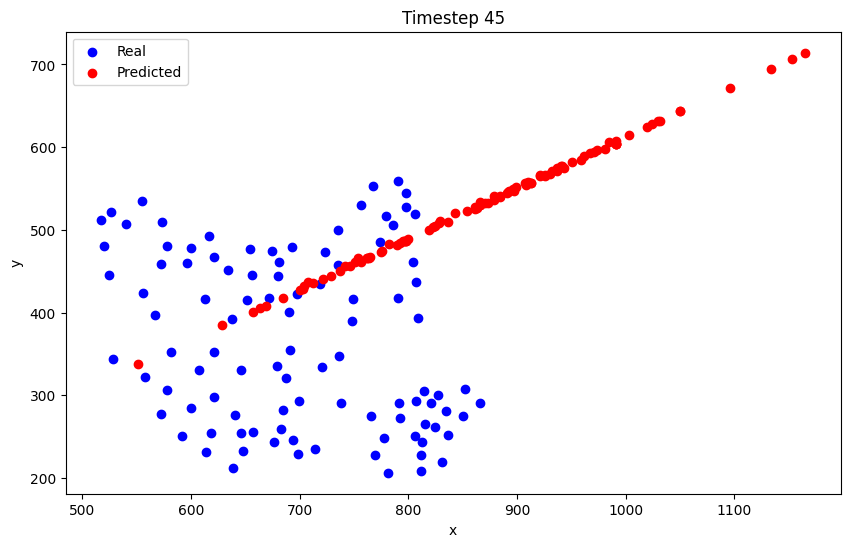

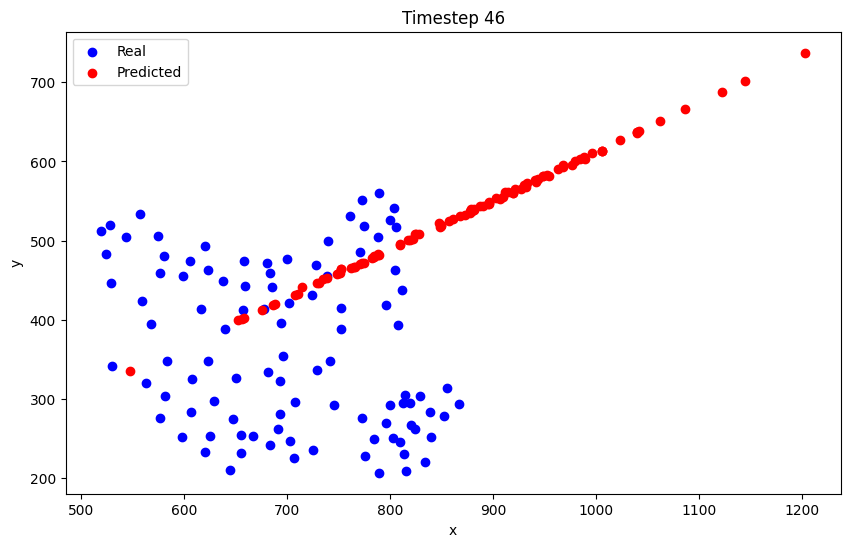

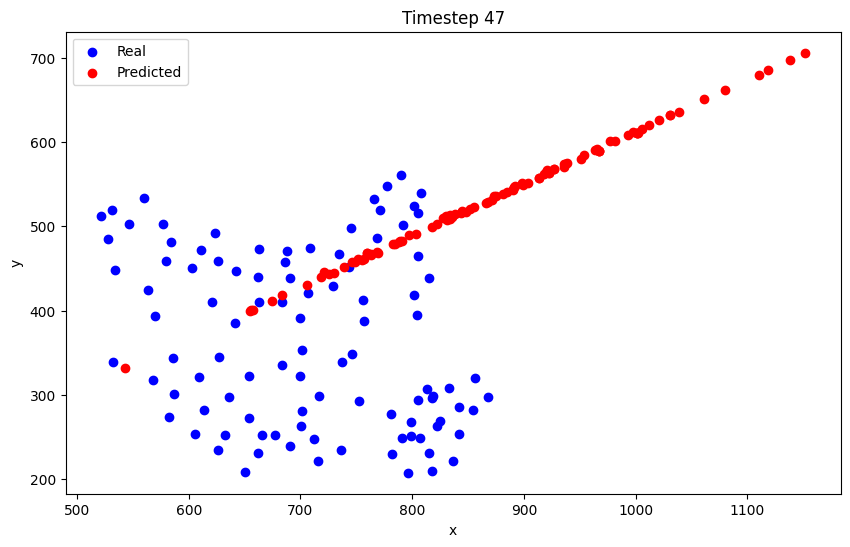

In [6]:
import math
import random
import pygame
import sys
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
import matplotlib.pyplot as plt

# Size of canvas
width = 1000
height = 750
numBoids = 100
visualRange = 75
boids = []

def initBoids():
    global boids
    boids = []
    for i in range(numBoids):
        boids.append({
            'x': random.random() * width,
            'y': random.random() * height,
            'dx': random.random() * 10 - 5,
            'dy': random.random() * 10 - 5,
            'history': [],
        })

def distance(boid1, boid2):
    return math.sqrt((boid1['x'] - boid2['x'])**2 + (boid1['y'] - boid2['y'])**2)

def sizeCanvas():
    global width, height
    size = (width, height)
    return pygame.display.set_mode(size)

def keepWithinBounds(boid):
    margin = 200
    turnFactor = 1
    if boid['x'] < margin:
        boid['dx'] += turnFactor
    if boid['x'] > width - margin:
        boid['dx'] -= turnFactor
    if boid['y'] < margin:
        boid['dy'] += turnFactor
    if boid['y'] > height - margin:
        boid['dy'] -= turnFactor

def flyTowardsCenter(boid):
    centeringFactor = 0.005
    centerX = 0
    centerY = 0
    numNeighbors = 0
    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            centerX += otherBoid['x']
            centerY += otherBoid['y']
            numNeighbors += 1
    if numNeighbors:
        centerX /= numNeighbors
        centerY /= numNeighbors
        boid['dx'] += (centerX - boid['x']) * centeringFactor
        boid['dy'] += (centerY - boid['y']) * centeringFactor

def avoidOthers(boid):
    minDistance = 20
    avoidFactor = 0.05
    moveX = 0
    moveY = 0
    for otherBoid in boids:
        if otherBoid != boid:
            if distance(boid, otherBoid) < minDistance:
                moveX += boid['x'] - otherBoid['x']
                moveY += boid['y'] - otherBoid['y']
    boid['dx'] += moveX * avoidFactor
    boid['dy'] += moveY * avoidFactor

def matchVelocity(boid):
    matchingFactor = 0.05
    avgDX = 0
    avgDY = 0
    numNeighbors = 0
    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            avgDX += otherBoid['dx']
            avgDY += otherBoid['dy']
            numNeighbors += 1
    if numNeighbors:
        avgDX /= numNeighbors
        avgDY /= numNeighbors
        boid['dx'] += (avgDX - boid['dx']) * matchingFactor
        boid['dy'] += (avgDY - boid['dy']) * matchingFactor

def limitSpeed(boid):
    speedLimit = 15
    speed = math.sqrt(boid['dx']**2 + boid['dy']**2)
    if speed > speedLimit:
        boid['dx'] = (boid['dx'] / speed) * speedLimit
        boid['dy'] = (boid['dy'] / speed) * speedLimit

def drawBoid(screen, boid):
    angle = math.atan2(boid['dy'], boid['dx'])
    boid_surface = pygame.Surface((30, 10), pygame.SRCALPHA)
    pygame.draw.polygon(boid_surface, (85, 140, 244), [
        (0, 0), (0, 10), (-15, 5)
    ])
    rotated_boid = pygame.transform.rotate(boid_surface, math.degrees(angle))
    rotated_rect = rotated_boid.get_rect(center=(boid['x'], boid['y']))
    screen.blit(rotated_boid, rotated_rect)

    if DRAW_TRAIL:
        for point in boid['history']:
            pygame.draw.circle(screen, (85, 140, 244, 102), (int(point[0]), int(point[1])), 1)

def animationLoop():
    global boids
    for boid in boids:
        flyTowardsCenter(boid)
        avoidOthers(boid)
        matchVelocity(boid)
        limitSpeed(boid)
        keepWithinBounds(boid)

        boid['x'] += boid['dx']
        boid['y'] += boid['dy']
        boid['history'].append((boid['x'], boid['y']))
        boid['history'] = boid['history'][-50:]

    screen.fill((255, 255, 255))
    for boid in boids:
        drawBoid(screen, boid)

    pygame.display.flip()
    pygame.time.Clock().tick(60)

# Save simulation data
pygame.init()
screen = sizeCanvas()
DRAW_TRAIL = False
num_time_steps = 100
num_sims = 10

for k in range(num_sims):
    initBoids()
    for _ in range(num_time_steps):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
        animationLoop()

    time_list = []
    for i in range(len(boids[0]["history"])):
        boid_dict = {}
        if i == 0:
            continue
        else:
            for j in range(len(boids)):
                dic = {}
                dic['x'] = boids[j]['history'][i][0]
                dic['y'] = boids[j]['history'][i][1]
                dic['dx'] = boids[j]['history'][i][0] - boids[j]['history'][i-1][0]
                dic['dy'] = boids[j]['history'][i][1] - boids[j]['history'][i-1][1]
                boid_dict[f'boid{j}'] = dic

        time_list.append(boid_dict)

    with open(f"../data/myjson/mydata{k}.json", "w") as final:
        json.dump(time_list, final)

pygame.quit()

# Load and preprocess data
def load_and_preprocess_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    num_timesteps = len(data)
    num_boids = len(data[0])

    features_list = []
    adjacency_matrices = []

    for t in range(num_timesteps):
        features = np.zeros((num_boids, 4))
        for i in range(num_boids):
            boid_data = data[t][f'boid{i}']
            features[i, 0] = boid_data['x']
            features[i, 1] = boid_data['y']
            features[i, 2] = boid_data['dx']
            features[i, 3] = boid_data['dy']
        
        adjacency_matrix = np.zeros((num_boids, num_boids))
        for i in range(num_boids):
            for j in range(num_boids):
                if i != j and distance(data[t][f'boid{i}'], data[t][f'boid{j}']) < visualRange:
                    adjacency_matrix[i, j] = 1
        
        features_list.append(torch.tensor(features, dtype=torch.float))
        adjacency_matrices.append(torch.tensor(adjacency_matrix, dtype=torch.float))
    
    return features_list, adjacency_matrices

features_list, adjacency_matrices = load_and_preprocess_data("../data/myjson/mydata1.json")

print("Features shape:", features_list[0].shape)
print("Adjacency matrix shape:", adjacency_matrices[0].shape)

# Define GRNN Generator
class GRNNGenerator(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GRNNGenerator, self).__init__()
        self.encoder = GCNConv(in_channels, hidden_channels)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )
    
    def forward(self, features, edge_index):
        x = self.encoder(features, edge_index)
        x = F.relu(x)
        x = self.decoder(x)
        return x

# Initialize the generator
generator = GRNNGenerator(in_channels=4, hidden_channels=16, out_channels=4)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize the discriminator
discriminator = Discriminator(input_dim=4, hidden_dim=16)

# Hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 0.0002

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(num_epochs):
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        next_real_features = features_list[t + 1]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()

        # Train Discriminator
        d_optimizer.zero_grad()
        
        real_labels = torch.ones(next_real_features.size(0), 1)
        fake_labels = torch.zeros(next_real_features.size(0), 1)
        
        real_output = discriminator(next_real_features)
        d_loss_real = criterion(real_output, real_labels)
        
        fake_features = generator(real_features, edge_index)
        fake_output = discriminator(fake_features.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        
        fake_output = discriminator(fake_features)
        g_loss = criterion(fake_output, real_labels)
        
        g_loss.backward()
        g_optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{t+1}/{len(features_list)-1}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Plotting generator predictions
with torch.no_grad():
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()
        predicted_features = generator(real_features, edge_index).numpy()
        
        plt.figure(figsize=(10, 6))
        plt.scatter(real_features[:, 0], real_features[:, 1], c='blue', label='Real')
        plt.scatter(predicted_features[:, 0], predicted_features[:, 1], c='red', label='Predicted')
        plt.legend()
        plt.title(f'Timestep {t}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()


In [5]:
import math
import random
import pygame
import sys
import json

# Size of canvas. These get updated to fill the whole screen.
width = 1000
height = 750
boidneigbor = 3
numBoids = 100
visualRange = 75

boids = []

def initBoids():
    global boids
    boids = []
    for i in range(numBoids):
        boids.append({
            'x': random.random() * width,
            'y': random.random() * height,
            'dx': random.random() * 10 - 5,
            'dy': random.random() * 10 - 5,
            'history': [],
        })

def distance(boid1, boid2):
    return math.sqrt((boid1['x'] - boid2['x'])**2 + (boid1['y'] - boid2['y'])**2)

def nClosestBoids(boid, n):
    sorted_boids = sorted(boids, key=lambda other_boid: distance(boid, other_boid))
    return sorted_boids[1:n+1]

def sizeCanvas():
    global width, height
    size = (width, height)
    return pygame.display.set_mode(size)

def keepWithinBounds(boid):
    margin = 200
    turnFactor = 1

    if boid['x'] < margin:
        boid['dx'] += turnFactor
    if boid['x'] > width - margin:
        boid['dx'] -= turnFactor
    if boid['y'] < margin:
        boid['dy'] += turnFactor
    if boid['y'] > height - margin:
        boid['dy'] -= turnFactor

def flyTowardsCenter(boid):
    centeringFactor = 0.005

    centerX = 0
    centerY = 0
    numNeighbors = 0

    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            centerX += otherBoid['x']
            centerY += otherBoid['y']
            numNeighbors += 1

    if numNeighbors:
        centerX /= numNeighbors
        centerY /= numNeighbors

        boid['dx'] += (centerX - boid['x']) * centeringFactor
        boid['dy'] += (centerY - boid['y']) * centeringFactor

def avoidOthers(boid):
    minDistance = 20
    avoidFactor = 0.05
    moveX = 0
    moveY = 0

    for otherBoid in boids:
        if otherBoid != boid:
            if distance(boid, otherBoid) < minDistance:
                moveX += boid['x'] - otherBoid['x']
                moveY += boid['y'] - otherBoid['y']

    boid['dx'] += moveX * avoidFactor
    boid['dy'] += moveY * avoidFactor

def matchVelocity(boid):
    matchingFactor = 0.05

    avgDX = 0
    avgDY = 0
    numNeighbors = 0

    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            avgDX += otherBoid['dx']
            avgDY += otherBoid['dy']
            numNeighbors += 1

    if numNeighbors:
        avgDX /= numNeighbors
        avgDY /= numNeighbors

        boid['dx'] += (avgDX - boid['dx']) * matchingFactor
        boid['dy'] += (avgDY - boid['dy']) * matchingFactor

def limitSpeed(boid):
    speedLimit = 15

    speed = math.sqrt(boid['dx']**2 + boid['dy']**2)
    if speed > speedLimit:
        boid['dx'] = (boid['dx'] / speed) * speedLimit
        boid['dy'] = (boid['dy'] / speed) * speedLimit

def drawBoid(screen, boid):
    angle = math.atan2(boid['dy'], boid['dx'])
    boid_surface = pygame.Surface((30, 10), pygame.SRCALPHA)
    pygame.draw.polygon(boid_surface, (85, 140, 244), [
        (0, 0), (0, 10), (-15, 5)
    ])
    rotated_boid = pygame.transform.rotate(boid_surface, math.degrees(angle))
    rotated_rect = rotated_boid.get_rect(center=(boid['x'], boid['y']))
    screen.blit(rotated_boid, rotated_rect)

    if DRAW_TRAIL:
        for point in boid['history']:
            pygame.draw.circle(screen, (85, 140, 244, 102), (int(point[0]), int(point[1])), 1)

# Main animation loop
def animationLoop():
    global boids
    for boid in boids:
        flyTowardsCenter(boid)
        avoidOthers(boid)
        matchVelocity(boid)
        limitSpeed(boid)
        keepWithinBounds(boid)

        boid['x'] += boid['dx']
        boid['y'] += boid['dy']
        boid['history'].append((boid['x'], boid['y']))
        boid['history'] = boid['history'][-50:]

    screen.fill((255, 255, 255))
    for boid in boids:
        drawBoid(screen, boid)

    pygame.display.flip()
    pygame.time.Clock().tick(60)

pygame.init()
screen = sizeCanvas()
DRAW_TRAIL = False
num_time_steps = 100
num_sims = 10
velocities = []
positions = []

for k in range(num_sims): # run simulation num_sims times
    initBoids() # initialize boids with different positions, and velocities
    for _ in range(num_time_steps): # run animationLoop() for num_time_steps
        for event in pygame.event.get(): # code to quit the animation (if needed)
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
        animationLoop() # updates boids to have new positions and velocities

    time_list = []  # Ensure time_list is initialized

    for i in range(len(boids[1]["history"])):  # Go through the length of history
        boid_dict = {}  # Initialize the dictionary for the current time step
        if i == 0:
            continue
        else: 
            for j in range(len(boids)):  # Go through the number of boids for every second
                dic = {}  # Initialize the dictionary for the current boid
                dic['x'] = boids[j]['history'][i][0]
                dic['y'] = boids[j]['history'][i][1]
                dic['dx'] = boids[j]['history'][i][0] - boids[j]['history'][i-1][0]
                dic['dy'] = boids[j]['history'][i][1] - boids[j]['history'][i-1][1]

                boid_dict[f'boid{j}'] = dic

        time_list.append(boid_dict)  # Append the dictionary to the list

    with open(f"../data/myjson/mydata{k}.json", "w") as final:
        json.dump(time_list, final)


In [3]:
import math
import random
import pygame
import sys

# Size of canvas. These get updated to fill the whole screen.
width = 1000
height = 750
boidneigbor = 3
numBoids = 100
visualRange = 75

boids = []

def initBoids():
    global boids
    boids = []
    for i in range(numBoids):
        boids.append({
            'x': random.random() * width,
            'y': random.random() * height,
            'dx': random.random() * 10 - 5,
            'dy': random.random() * 10 - 5,
            'history': [],
        })

def distance(boid1, boid2):
    return math.sqrt((boid1['x'] - boid2['x'])**2 + (boid1['y'] - boid2['y'])**2)

def nClosestBoids(boid, n):
    sorted_boids = sorted(boids, key=lambda other_boid: distance(boid, other_boid))
    return sorted_boids[1:n+1]

def sizeCanvas():
    global width, height
    size = (width, height)
    return pygame.display.set_mode(size)

def keepWithinBounds(boid):
    margin = 200
    turnFactor = 1

    if boid['x'] < margin:
        boid['dx'] += turnFactor
    if boid['x'] > width - margin:
        boid['dx'] -= turnFactor
    if boid['y'] < margin:
        boid['dy'] += turnFactor
    if boid['y'] > height - margin:
        boid['dy'] -= turnFactor

def flyTowardsCenter(boid):
    centeringFactor = 0.005

    centerX = 0
    centerY = 0
    numNeighbors = 0

    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            centerX += otherBoid['x']
            centerY += otherBoid['y']
            numNeighbors += 1

    if numNeighbors:
        centerX /= numNeighbors
        centerY /= numNeighbors

        boid['dx'] += (centerX - boid['x']) * centeringFactor
        boid['dy'] += (centerY - boid['y']) * centeringFactor

def avoidOthers(boid):
    minDistance = 20
    avoidFactor = 0.05
    moveX = 0
    moveY = 0

    for otherBoid in boids:
        if otherBoid != boid:
            if distance(boid, otherBoid) < minDistance:
                moveX += boid['x'] - otherBoid['x']
                moveY += boid['y'] - otherBoid['y']

    boid['dx'] += moveX * avoidFactor
    boid['dy'] += moveY * avoidFactor

def matchVelocity(boid):
    matchingFactor = 0.05

    avgDX = 0
    avgDY = 0
    numNeighbors = 0

    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            avgDX += otherBoid['dx']
            avgDY += otherBoid['dy']
            numNeighbors += 1

    if numNeighbors:
        avgDX /= numNeighbors
        avgDY /= numNeighbors

        boid['dx'] += (avgDX - boid['dx']) * matchingFactor
        boid['dy'] += (avgDY - boid['dy']) * matchingFactor

def limitSpeed(boid):
    speedLimit = 15

    speed = math.sqrt(boid['dx']**2 + boid['dy']**2)
    if speed > speedLimit:
        boid['dx'] = (boid['dx'] / speed) * speedLimit
        boid['dy'] = (boid['dy'] / speed) * speedLimit

def drawBoid(screen, boid):
    angle = math.atan2(boid['dy'], boid['dx'])
    boid_surface = pygame.Surface((30, 10), pygame.SRCALPHA)
    pygame.draw.polygon(boid_surface, (85, 140, 244), [
        (0, 0), (0, 10), (-15, 5)
    ])
    rotated_boid = pygame.transform.rotate(boid_surface, math.degrees(angle))
    rotated_rect = rotated_boid.get_rect(center=(boid['x'], boid['y']))
    screen.blit(rotated_boid, rotated_rect)

    if DRAW_TRAIL:
        for point in boid['history']:
            pygame.draw.circle(screen, (85, 140, 244, 102), (int(point[0]), int(point[1])), 1)

# Main animation loop
def animationLoop():
    global boids
    for boid in boids:
        flyTowardsCenter(boid)
        avoidOthers(boid)
        matchVelocity(boid)
        limitSpeed(boid)
        keepWithinBounds(boid)

        boid['x'] += boid['dx']
        boid['y'] += boid['dy']
        boid['history'].append((boid['x'], boid['y']))
        boid['history'] = boid['history'][-50:]

    screen.fill((255, 255, 255))
    for boid in boids:
        drawBoid(screen, boid)

    pygame.display.flip()
    pygame.time.Clock().tick(60)

pygame.init()
screen = sizeCanvas()
DRAW_TRAIL = False
num_time_steps = 100
num_sims = 10
velocities = []
positions = []

for k in range(num_sims): # run simulation num_sims times
    initBoids() # initialize boids with different positions, and velocities
    for _ in range(num_time_steps): # run animationLoop() for num_time_steps
        for event in pygame.event.get(): # code to quit the animation (if needed)
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
        animationLoop() # updates boids to have new positions and velocities

    time_list = []  # Ensure time_list is initialized

    for i in range(len(boids[1]["history"])):  # Go through the length of history
        boid_dict = {}  # Initialize the dictionary for the current time step
        if i == 0:
            continue
        else: 
            for j in range(len(boids)):  # Go through the number of boids for every second
                dic = {}  # Initialize the dictionary for the current boid
                dic['x'] = boids[j]['history'][i][0]
                dic['y'] = boids[j]['history'][i][1]
                dic['dx'] = boids[j]['history'][i][0] - boids[j]['history'][i-1][0]
                dic['dy'] = boids[j]['history'][i][1] - boids[j]['history'][i-1][1]

                boid_dict[f'boid{j}'] = dic

        time_list.append(boid_dict)  # Append the dictionary to the list

    with open(f"../data/myjson/mydata{k}.json", "w") as final:
        json.dump(time_list, final)

import json
import numpy as np


def load_and_preprocess_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    num_timesteps = len(data)
    num_boids = len(data[0])

    features_list = []
    adjacency_matrices = []

    for t in range(num_timesteps):
        features = np.zeros((num_boids, 4))
        for i in range(num_boids):
            boid_data = data[t][f'boid{i}']
            features[i, 0] = boid_data['x']
            features[i, 1] = boid_data['y']
            features[i, 2] = boid_data['dx']
            features[i, 3] = boid_data['dy']
        
        adjacency_matrix = np.zeros((num_boids, num_boids))
        for i in range(num_boids):
            for j in range(num_boids):
                if i != j and distance(data[t][f'boid{i}'], data[t][f'boid{j}']) < visualRange:
                    adjacency_matrix[i, j] = 1
        
        features_list.append(torch.tensor(features, dtype=torch.float))
        adjacency_matrices.append(torch.tensor(adjacency_matrix, dtype=torch.float))
    
    return features_list, adjacency_matrices

features_list, adjacency_matrices = load_and_preprocess_data("../data/myjson/mydata1.json")

print("Features shape:", features_list[0].shape)
print("Adjacency matrix shape:", adjacency_matrices[0].shape)

class GRNNGenerator(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GRNNGenerator, self).__init__()
        self.encoder = GCNConv(in_channels, hidden_channels)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )
    
    def forward(self, features, edge_index):
        x = self.encoder(features, edge_index)
        x = F.relu(x)
        x = self.decoder(x)
        return x

# Initialize the generator
generator = GRNNGenerator(in_channels=4, hidden_channels=16, out_channels=4)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize the discriminator
discriminator = Discriminator(input_dim=4, hidden_dim=16)

import torch.optim as optim

# Hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 0.0002

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
criterion = nn.BCELoss()

for epoch in range(num_epochs):
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        next_real_features = features_list[t + 1]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()

        # Train Discriminator
        d_optimizer.zero_grad()
        
        real_labels = torch.ones(next_real_features.size(0), 1)
        fake_labels = torch.zeros(next_real_features.size(0), 1)
        
        real_output = discriminator(next_real_features)
        d_loss_real = criterion(real_output, real_labels)
        
        fake_features = generator(real_features, edge_index)
        fake_output = discriminator(fake_features.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        
        fake_output = discriminator(fake_features)
        g_loss = criterion(fake_output, real_labels)
        
        g_loss.backward()
        g_optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{t+1}/{len(features_list)-1}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')





pygame 2.6.0 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


NameError: name 'json' is not defined

In [75]:
adjacency_matrices

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

In [76]:

class GRNNGenerator(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GRNNGenerator, self).__init__()
        self.encoder = GCNConv(in_channels, hidden_channels)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )
    
    def forward(self, features, edge_index):
        x = self.encoder(features, edge_index)
        x = F.relu(x)
        x = self.decoder(x)
        return x

# Initialize the generator
generator = GRNNGenerator(in_channels=4, hidden_channels=16, out_channels=4)


In [77]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize the discriminator
discriminator = Discriminator(input_dim=4, hidden_dim=16)


In [78]:
import torch.optim as optim

# Hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 0.0002

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
criterion = nn.BCELoss()

for epoch in range(num_epochs):
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        next_real_features = features_list[t + 1]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()

        # Train Discriminator
        d_optimizer.zero_grad()
        
        real_labels = torch.ones(next_real_features.size(0), 1)
        fake_labels = torch.zeros(next_real_features.size(0), 1)
        
        real_output = discriminator(next_real_features)
        d_loss_real = criterion(real_output, real_labels)
        
        fake_features = generator(real_features, edge_index)
        fake_output = discriminator(fake_features.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        
        fake_output = discriminator(fake_features)
        g_loss = criterion(fake_output, real_labels)
        
        g_loss.backward()
        g_optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{t+1}/{len(features_list)-1}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')


Epoch [1/100], Step [1/48], D Loss: 39.539642333984375, G Loss: 2.2745399475097656
Epoch [1/100], Step [2/48], D Loss: 38.815277099609375, G Loss: 2.2188220024108887
Epoch [1/100], Step [3/48], D Loss: 38.105979919433594, G Loss: 2.1645171642303467
Epoch [1/100], Step [4/48], D Loss: 37.4094123840332, G Loss: 2.103611707687378
Epoch [1/100], Step [5/48], D Loss: 36.73126220703125, G Loss: 2.046788215637207
Epoch [1/100], Step [6/48], D Loss: 36.07036209106445, G Loss: 1.9891107082366943
Epoch [1/100], Step [7/48], D Loss: 35.43912887573242, G Loss: 1.9295530319213867
Epoch [1/100], Step [8/48], D Loss: 34.82838821411133, G Loss: 1.8704625368118286
Epoch [1/100], Step [9/48], D Loss: 34.236026763916016, G Loss: 1.8129682540893555
Epoch [1/100], Step [10/48], D Loss: 33.674808502197266, G Loss: 1.7561792135238647
Epoch [1/100], Step [11/48], D Loss: 33.13755798339844, G Loss: 1.7022534608840942
Epoch [1/100], Step [12/48], D Loss: 32.6234130859375, G Loss: 1.6457998752593994
Epoch [1/100

In [82]:
import matplotlib.pyplot as plt

def plot_trajectories(actual_trajectories, predicted_trajectories, num_boids=5):
    plt.figure(figsize=(15, 7))
    
    for boid_id in range(num_boids):
        actual_x = [state[boid_id, 0] for state in actual_trajectories]
        actual_y = [state[boid_id, 1] for state in actual_trajectories]
        predicted_x = [state[boid_id, 0] for state in predicted_trajectories]
        predicted_y = [state[boid_id, 1] for state in predicted_trajectories]

        plt.plot(actual_x, actual_y, label=f'Actual Boid {boid_id}')
        plt.plot(predicted_x, predicted_y, linestyle='--', label=f'Predicted Boid {boid_id}')
    
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Actual vs Predicted Trajectories')
    plt.legend()
    plt.show()


[tensor([[ 4.8565e+02,  4.9865e+02, -4.4808e-01,  3.1092e+00],
         [ 5.7315e+02,  3.4831e+02,  3.5931e+00, -1.2002e+00],
         [ 5.0953e+02,  1.8098e+02,  2.2672e-01, -8.2478e-01],
         [ 4.6038e+02,  4.2373e+02,  1.2252e+00,  4.9719e+00],
         [ 5.7796e+02,  5.6115e+02, -5.5824e+00,  5.3402e+00],
         [ 4.8054e+02,  5.8102e+02,  3.9344e+00,  2.8450e+00],
         [ 4.7293e+02,  3.4022e+02, -3.8482e+00,  1.7339e+00],
         [ 5.9139e+02,  2.7241e+02, -1.2216e+00, -3.4659e+00],
         [ 5.3828e+02,  5.7751e+02,  2.7366e+00,  2.5594e+00],
         [ 5.4942e+02,  5.7693e+02, -3.6455e+00,  2.9636e+00],
         [ 5.0673e+02,  5.1766e+02,  2.2585e-01,  6.3820e+00],
         [ 5.3065e+02,  5.9697e+02, -5.7479e+00,  3.8160e+00],
         [ 3.4577e+02,  1.3986e+02,  5.6816e+00, -2.6572e+00],
         [ 3.1851e+02,  2.7273e+02, -9.1600e+00, -3.1298e+00],
         [ 5.6356e+02,  2.4496e+02,  8.4302e+00, -2.3380e+00],
         [ 5.5945e+02,  3.2623e+02, -3.4345e+00, -1.424

In [89]:
import math
import random
import pygame
import sys
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

# Size of canvas
width, height = 1000, 750
boidneigbor, numBoids, visualRange = 3, 100, 75

boids = []

def initBoids():
    global boids
    boids = []
    for i in range(numBoids):
        boids.append({
            'x': random.random() * width,
            'y': random.random() * height,
            'dx': random.random() * 10 - 5,
            'dy': random.random() * 10 - 5,
            'history': [],
        })

def distance(boid1, boid2):
    return math.sqrt((boid1['x'] - boid2['x'])**2 + (boid1['y'] - boid2['y'])**2)

def sizeCanvas():
    global width, height
    size = (width, height)
    return pygame.display.set_mode(size)

def flyTowardsCenter(boid):
    centeringFactor = 0.005
    centerX, centerY, numNeighbors = 0, 0, 0

    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            centerX += otherBoid['x']
            centerY += otherBoid['y']
            numNeighbors += 1

    if numNeighbors:
        centerX /= numNeighbors
        centerY /= numNeighbors
        boid['dx'] += (centerX - boid['x']) * centeringFactor
        boid['dy'] += (centerY - boid['y']) * centeringFactor

def avoidOthers(boid):
    minDistance = 20
    avoidFactor = 0.05
    moveX, moveY = 0, 0

    for otherBoid in boids:
        if otherBoid != boid and distance(boid, otherBoid) < minDistance:
            moveX += boid['x'] - otherBoid['x']
            moveY += boid['y'] - otherBoid['y']

    boid['dx'] += moveX * avoidFactor
    boid['dy'] += moveY * avoidFactor

def matchVelocity(boid):
    matchingFactor = 0.05
    avgDX, avgDY, numNeighbors = 0, 0, 0

    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            avgDX += otherBoid['dx']
            avgDY += otherBoid['dy']
            numNeighbors += 1

    if numNeighbors:
        avgDX /= numNeighbors
        avgDY /= numNeighbors
        boid['dx'] += (avgDX - boid['dx']) * matchingFactor
        boid['dy'] += (avgDY - boid['dy']) * matchingFactor

def limitSpeed(boid):
    speedLimit = 15
    speed = math.sqrt(boid['dx']**2 + boid['dy']**2)
    if speed > speedLimit:
        boid['dx'] = (boid['dx'] / speed) * speedLimit
        boid['dy'] = (boid['dy'] / speed) * speedLimit

def drawBoid(screen, boid):
    angle = math.atan2(boid['dy'], boid['dx'])
    boid_surface = pygame.Surface((30, 10), pygame.SRCALPHA)
    pygame.draw.polygon(boid_surface, (85, 140, 244), [(0, 0), (0, 10), (-15, 5)])
    rotated_boid = pygame.transform.rotate(boid_surface, math.degrees(angle))
    rotated_rect = rotated_boid.get_rect(center=(boid['x'], boid['y']))
    screen.blit(rotated_boid, rotated_rect)

    if DRAW_TRAIL:
        for point in boid['history']:
            pygame.draw.circle(screen, (85, 140, 244, 102), (int(point[0]), int(point[1])), 1)

# Main animation loop
def animationLoop():
    global boids
    for boid in boids:
        flyTowardsCenter(boid)
        avoidOthers(boid)
        matchVelocity(boid)
        limitSpeed(boid)

        boid['x'] += boid['dx']
        boid['y'] += boid['dy']
        boid['history'].append((boid['x'], boid['y']))
        boid['history'] = boid['history'][-50:]

    screen.fill((255, 255, 255))
    for boid in boids:
        drawBoid(screen, boid)

    pygame.display.flip()
    pygame.time.Clock().tick(60)

class RecurrentGNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(RecurrentGNN, self).__init__(aggr='add')
        self.gru = nn.GRUCell(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        out = x
        for _ in range(3):
            out = self.propagate(edge_index, x=out)
        return out

    def message(self, x_j):
        return x_j

    def update(self, aggr_out, x):
        return self.gru(aggr_out, x)

pygame.init()
screen = sizeCanvas()
DRAW_TRAIL = False
num_time_steps = 100
num_sims = 10
velocities, positions = [], []

for k in range(num_sims):
    initBoids()
    for _ in range(num_time_steps):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
        animationLoop()

    time_list = []

    for i in range(len(boids[1]["history"])):
        boid_dict = {}
        if i == 0:
            continue
        else:
            for j in range(len(boids)):
                dic = {}
                dic['x'] = boids[j]['history'][i][0]
                dic['y'] = boids[j]['history'][i][1]
                dic['dx'] = boids[j]['history'][i][0] - boids[j]['history'][i-1][0]
                dic['dy'] = boids[j]['history'][i][1] - boids[j]['history'][i-1][1]
                boid_dict[f'boid{j}'] = dic
        time_list.append(boid_dict)

    with open(f"../data/myjson/mydata{k}.json", "w") as final:
        json.dump(time_list, final)

# Load data for training (example for one simulation)
with open(f"../data/myjson/mydata0.json", "r") as f:
    time_list = json.load(f)

# Convert data to graph format
def create_graph_data(time_list):
    node_features = []
    edge_index = [[], []]
    for time_step in time_list:
        for boid_id, boid_data in time_step.items():
            node_features.append([boid_data['x'], boid_data['y'], boid_data['dx'], boid_data['dy']])
            for other_boid_id, other_boid_data in time_step.items():
                if boid_id != other_boid_id:
                    edge_index[0].append(int(boid_id.replace('boid', '')))
                    edge_index[1].append(int(other_boid_id.replace('boid', '')))
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return Data(x=node_features, edge_index=edge_index)

data = create_graph_data(time_list)

# Initialize the model, optimizer, and loss function
model = RecurrentGNN(in_channels=4, out_channels=4)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Example training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.x)
    loss.backward()




RecurrentGNN()

In [90]:
loss 

tensor(5900.1851, grad_fn=<MseLossBackward0>)

Features shape: torch.Size([100, 4])
Adjacency matrix shape: torch.Size([100, 100])
Epoch [1/100], Step [1/48], D Loss: 0.01715521514415741, G Loss: 5.2282304763793945
Epoch [1/100], Step [2/48], D Loss: 0.01950976438820362, G Loss: 5.107217311859131
Epoch [1/100], Step [3/48], D Loss: 0.022219453006982803, G Loss: 4.984865188598633
Epoch [1/100], Step [4/48], D Loss: 0.024870717898011208, G Loss: 4.865328788757324
Epoch [1/100], Step [5/48], D Loss: 0.02800004929304123, G Loss: 4.745326042175293
Epoch [1/100], Step [6/48], D Loss: 0.031241150572896004, G Loss: 4.629837512969971
Epoch [1/100], Step [7/48], D Loss: 0.03387755900621414, G Loss: 4.51862096786499
Epoch [1/100], Step [8/48], D Loss: 0.0373111329972744, G Loss: 4.401124954223633
Epoch [1/100], Step [9/48], D Loss: 0.041236866265535355, G Loss: 4.281946182250977
Epoch [1/100], Step [10/48], D Loss: 0.045280229300260544, G Loss: 4.170428276062012
Epoch [1/100], Step [11/48], D Loss: 0.04966023564338684, G Loss: 4.0609846115112

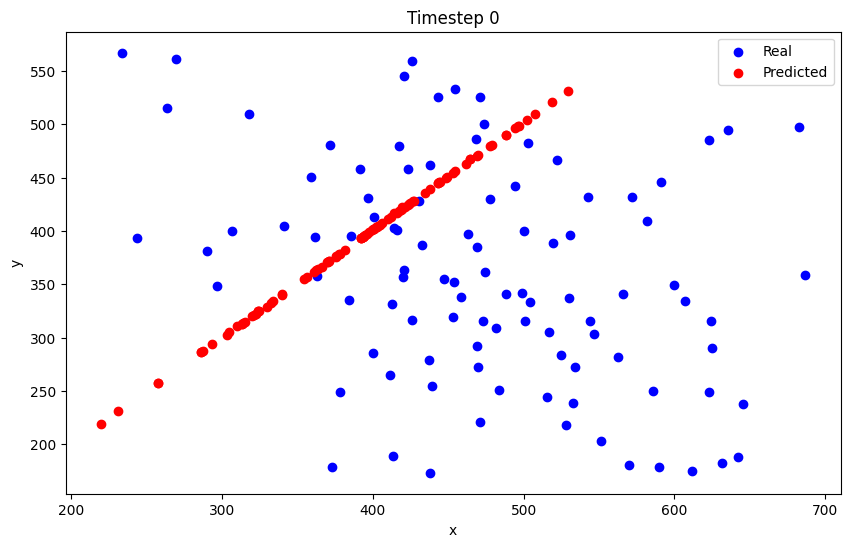

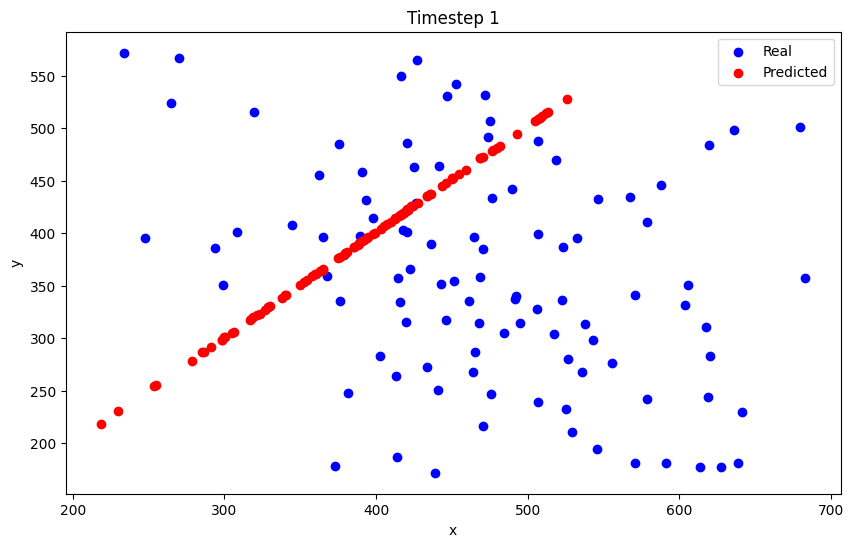

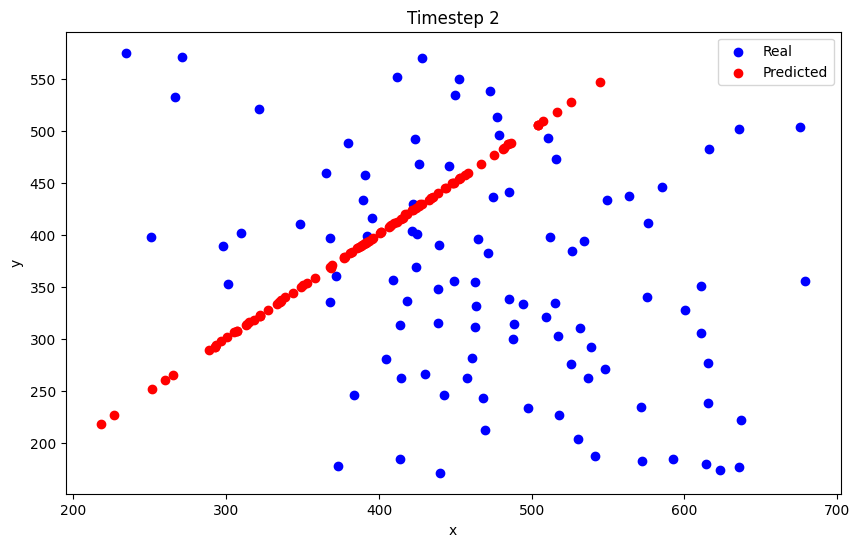

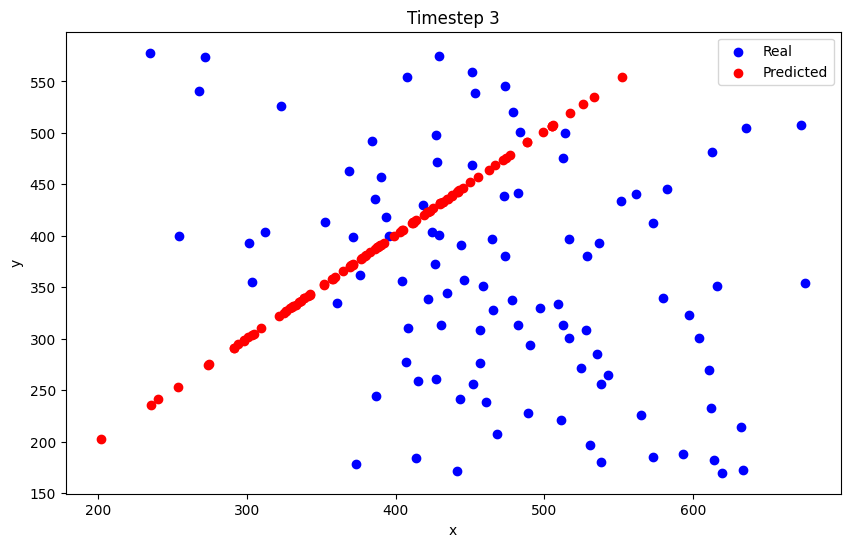

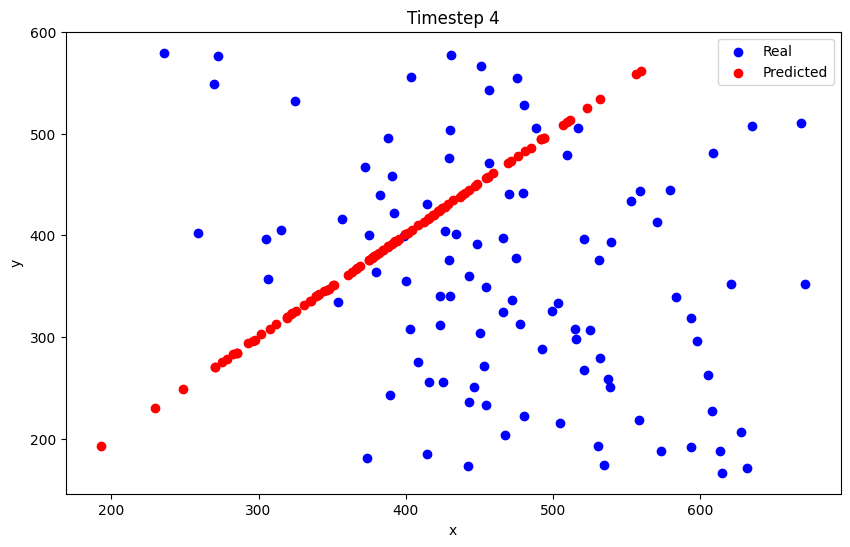

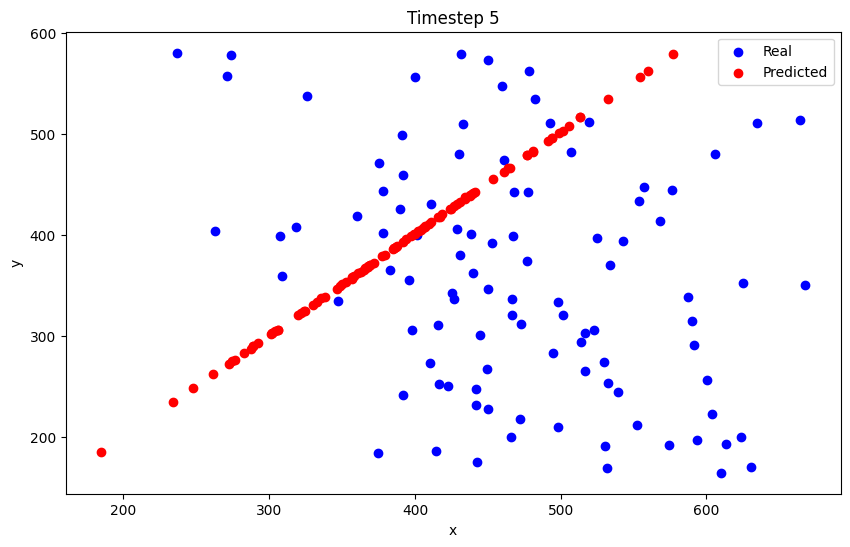

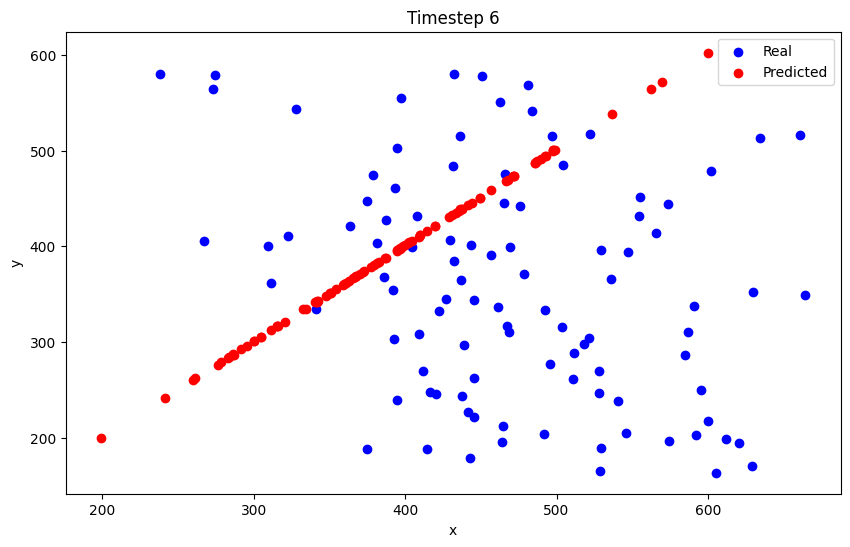

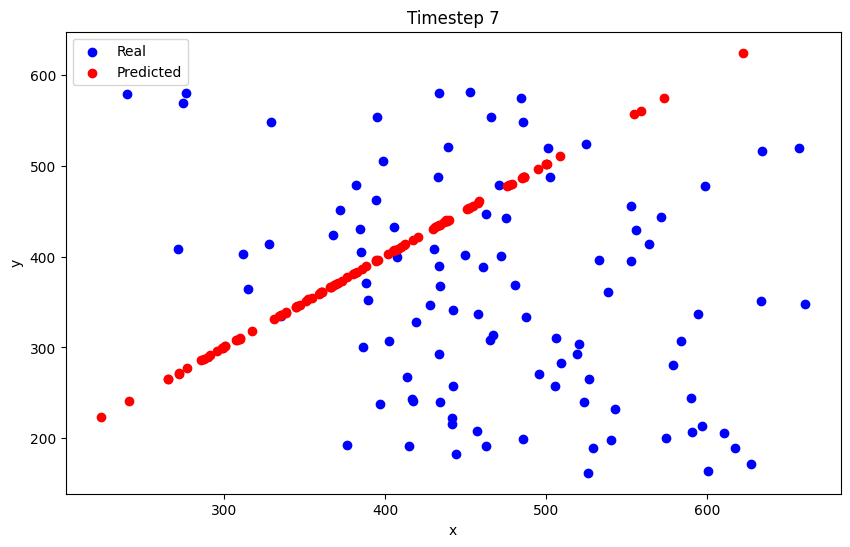

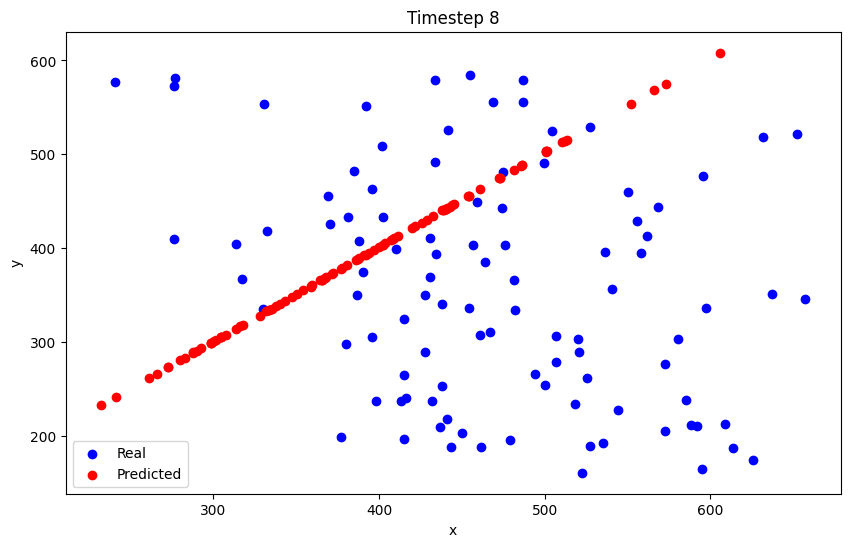

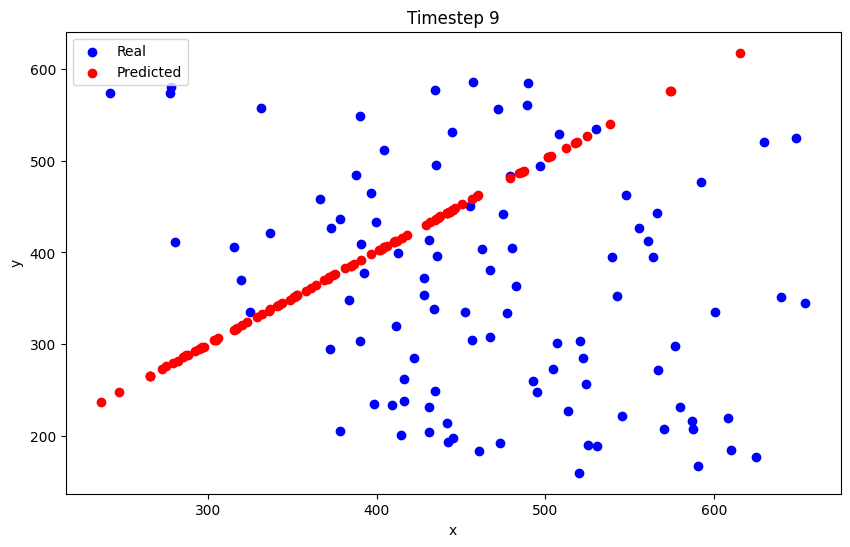

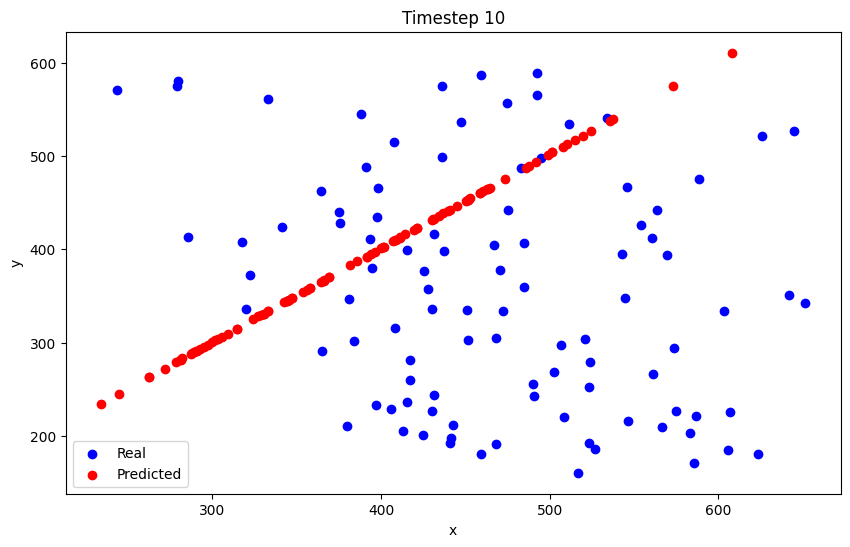

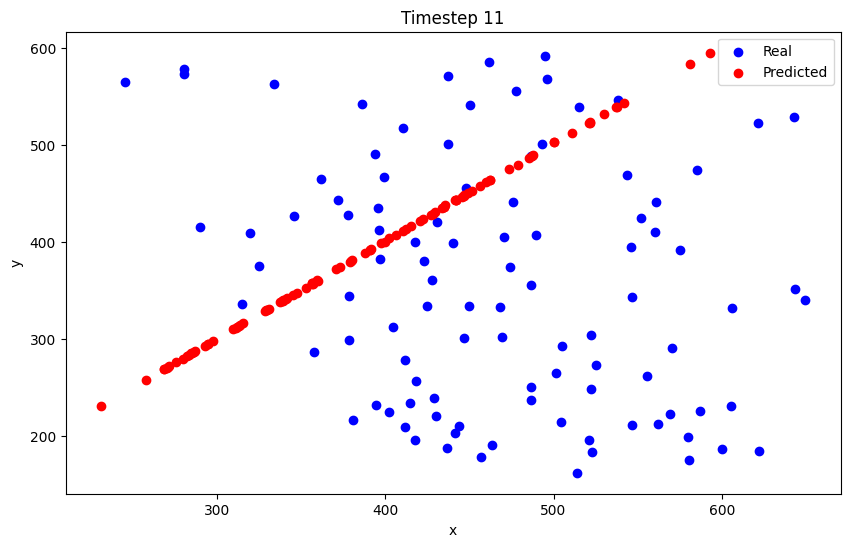

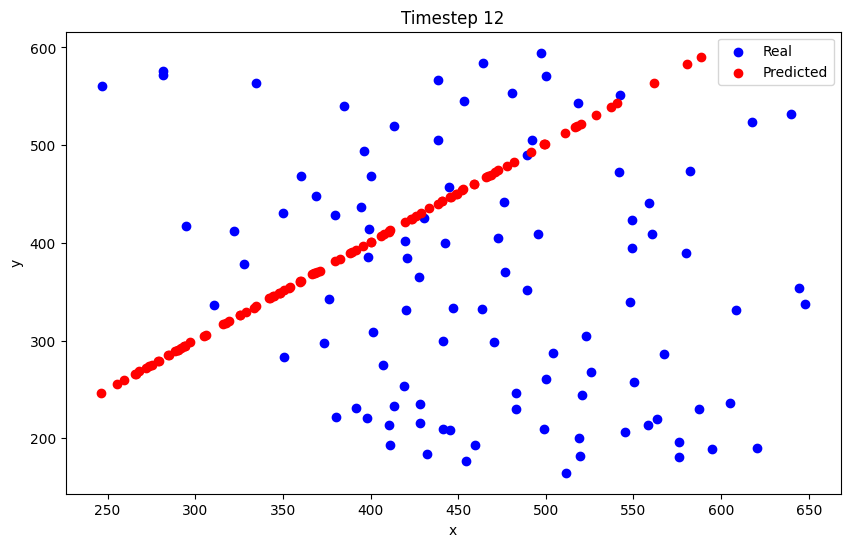

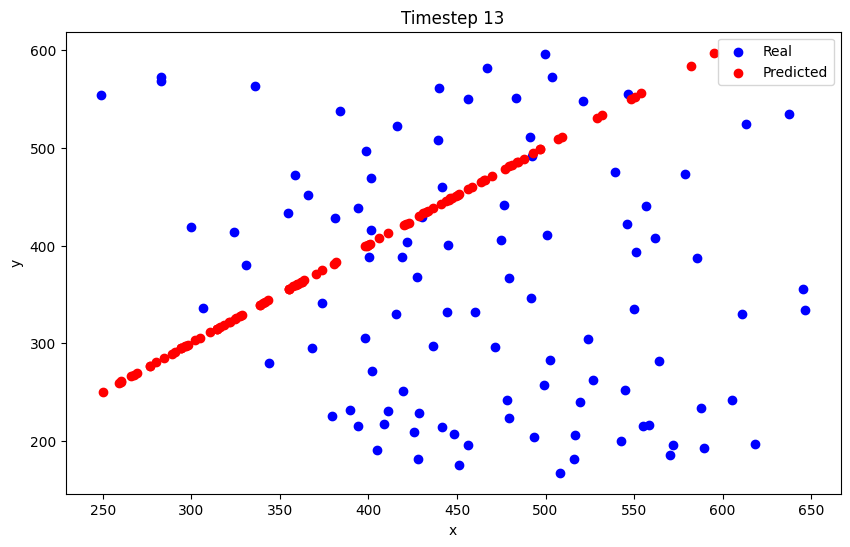

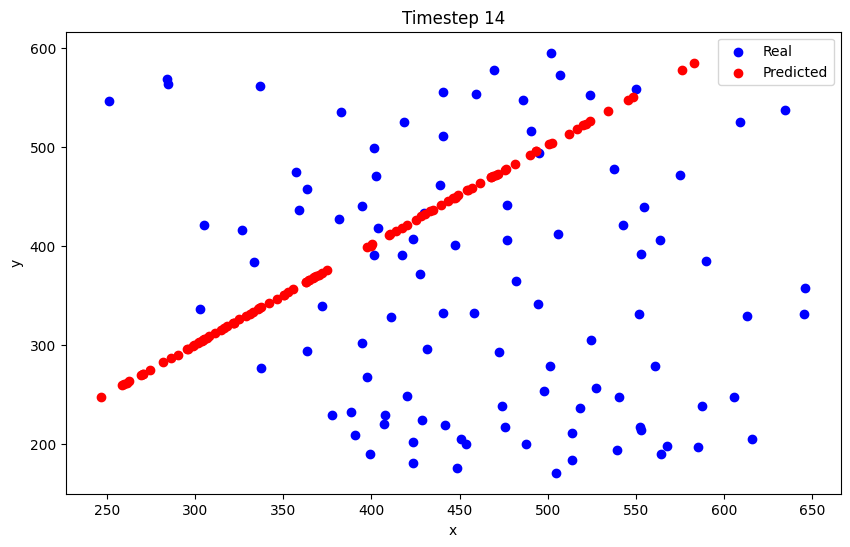

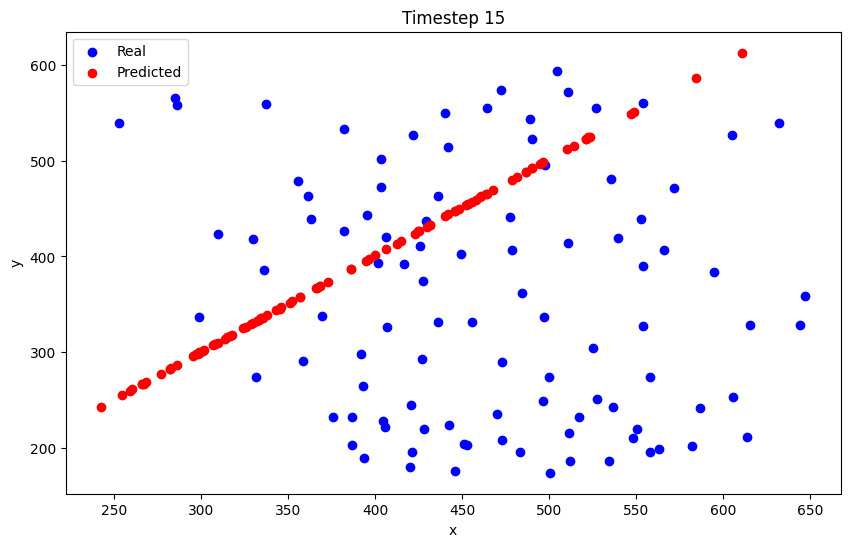

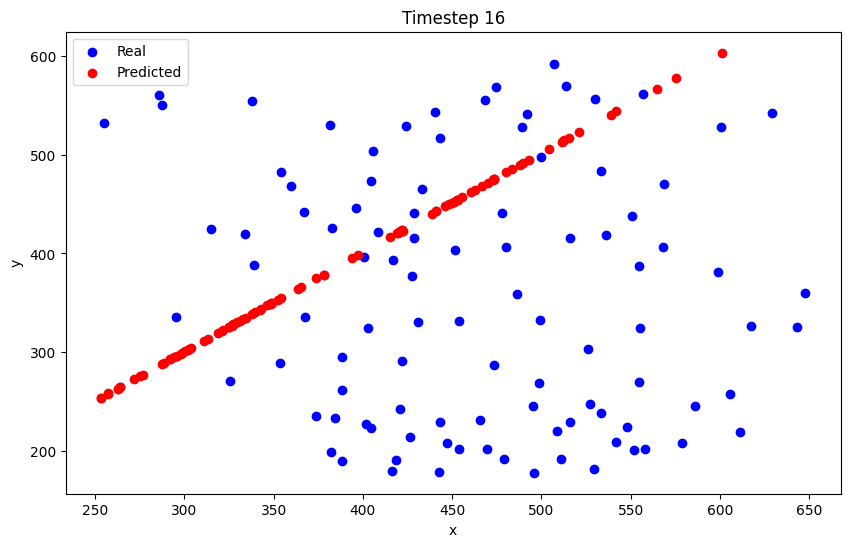

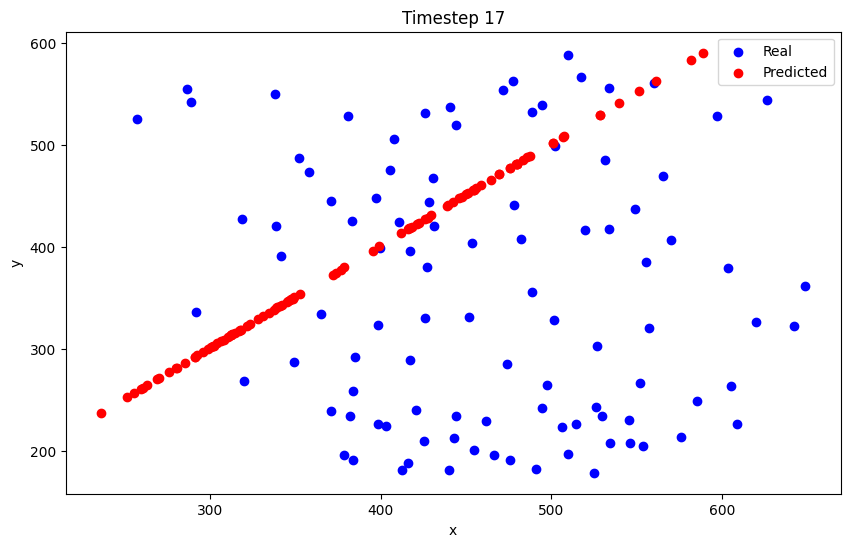

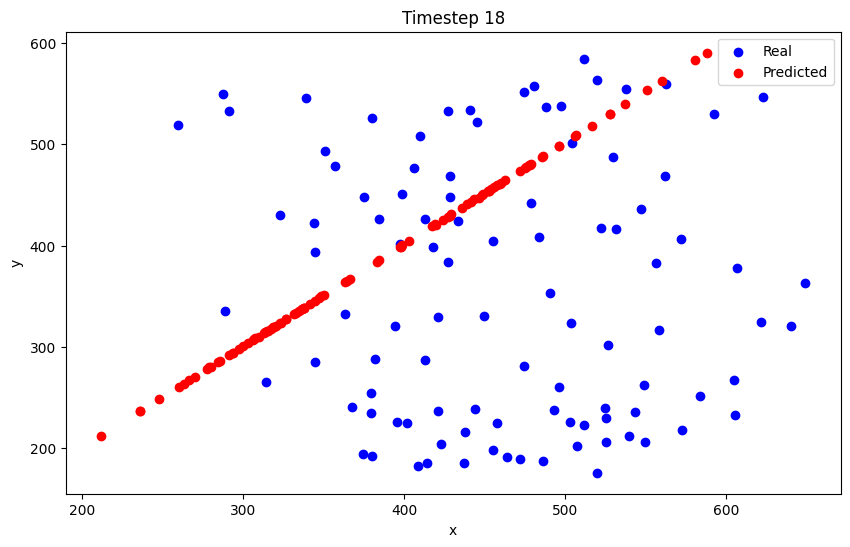

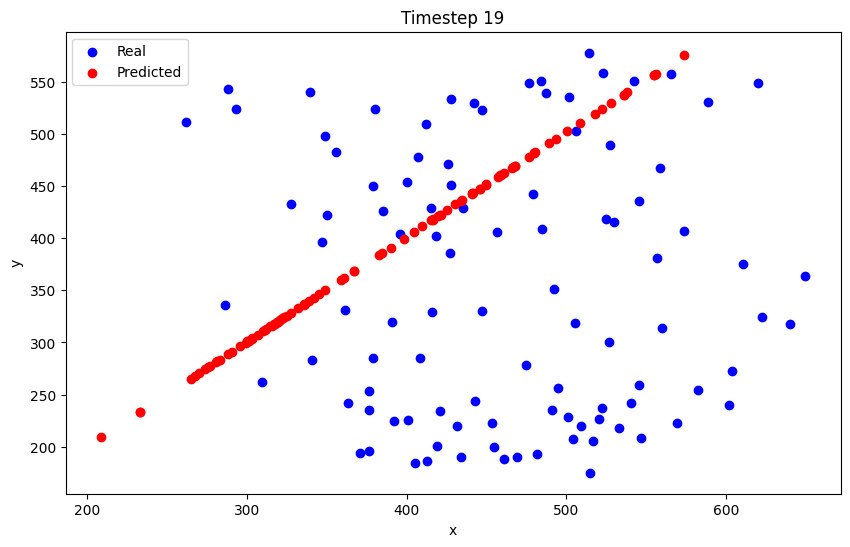

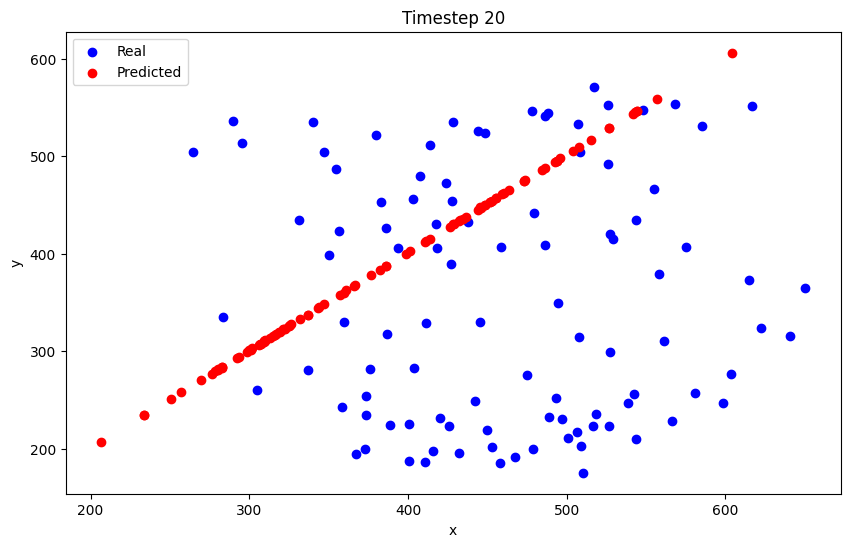

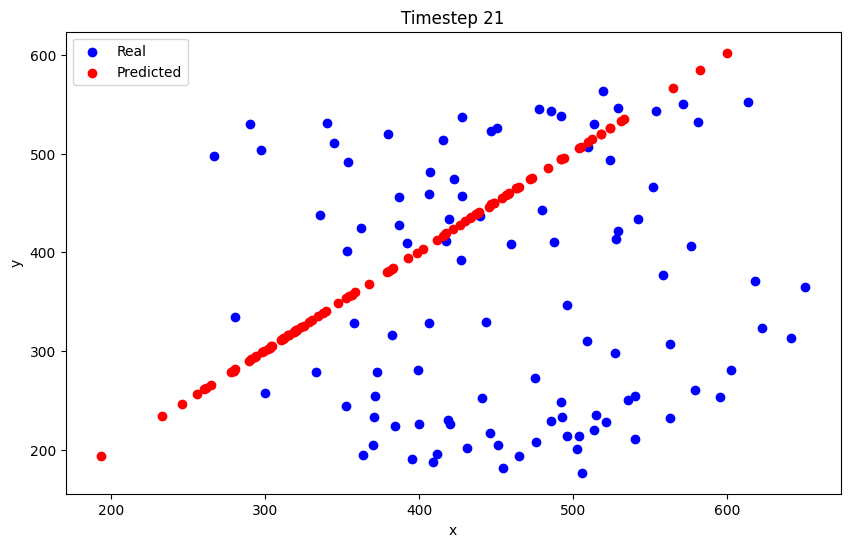

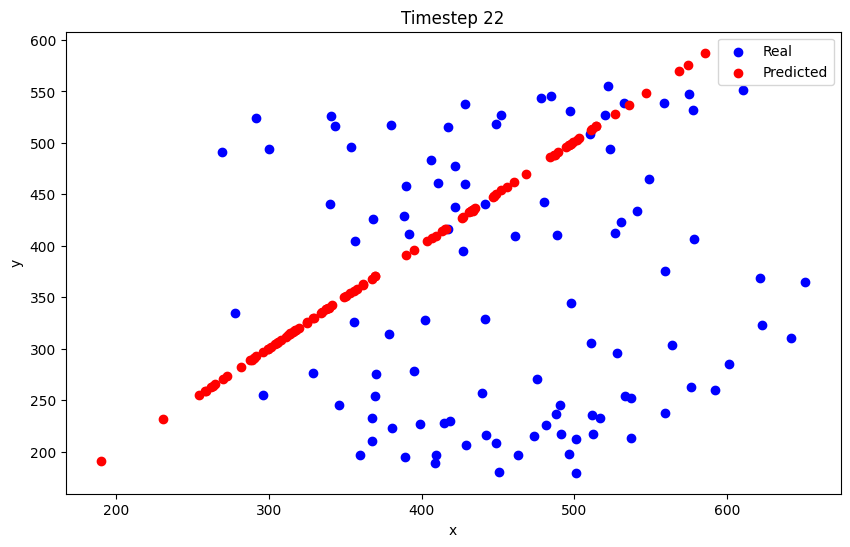

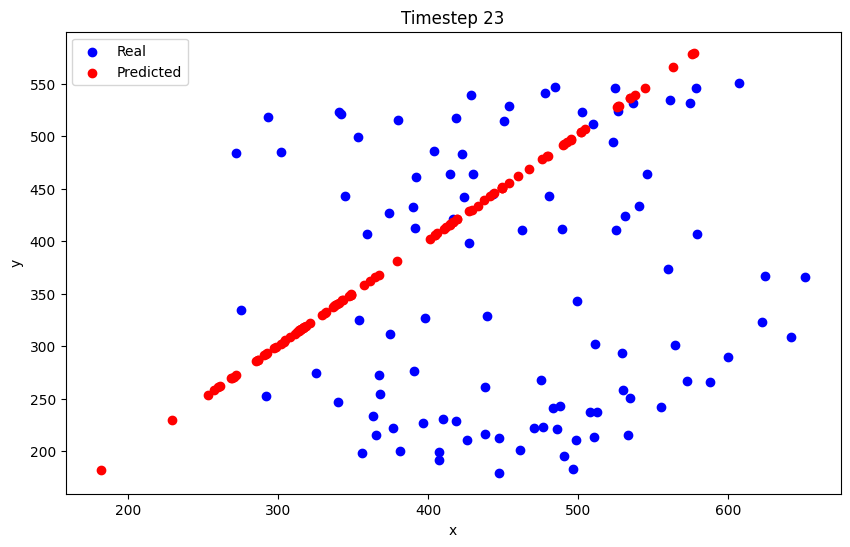

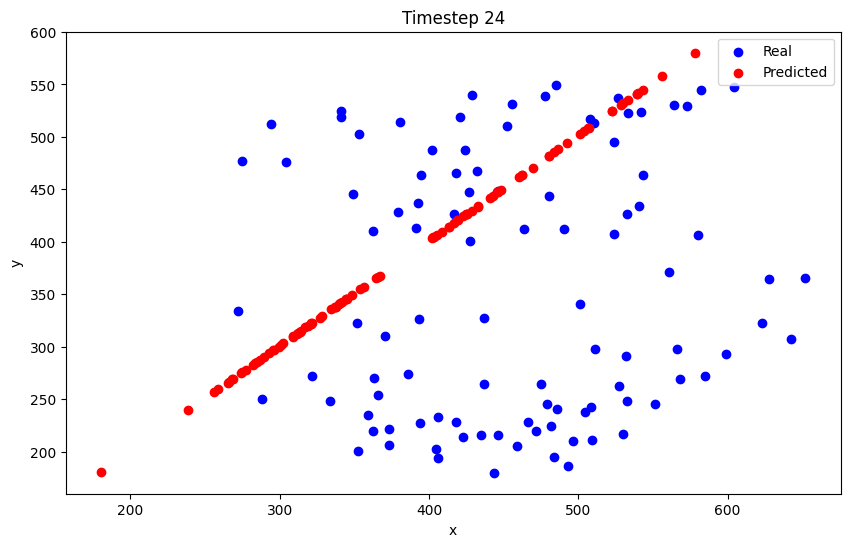

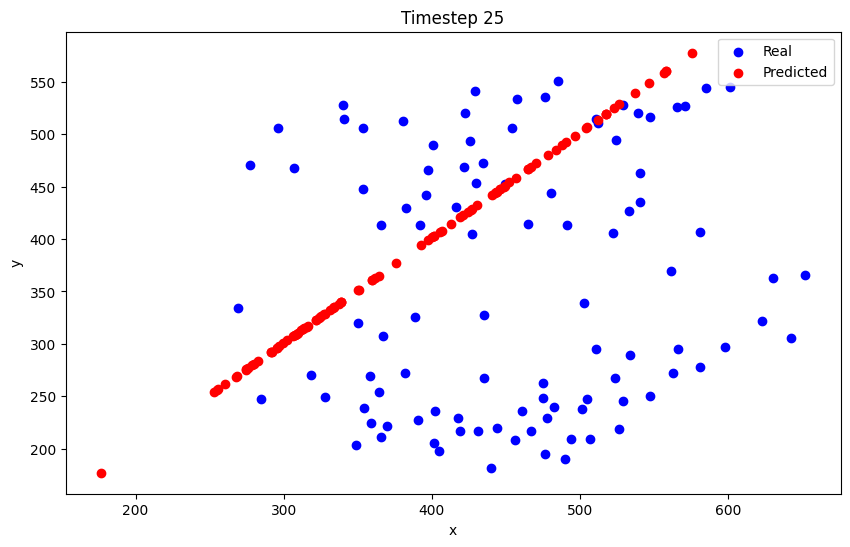

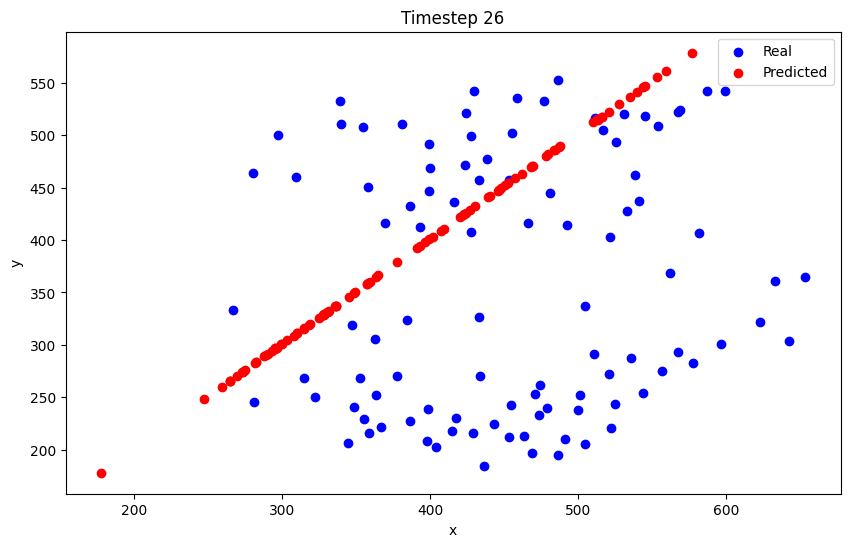

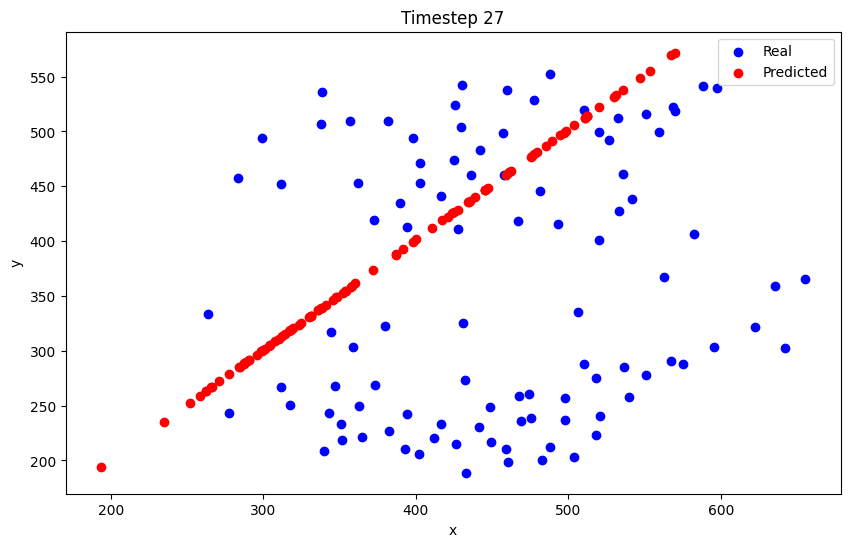

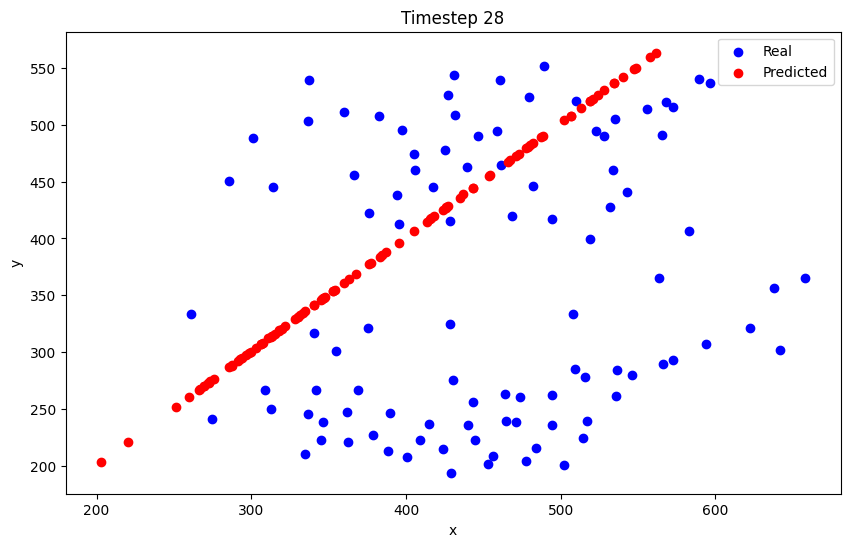

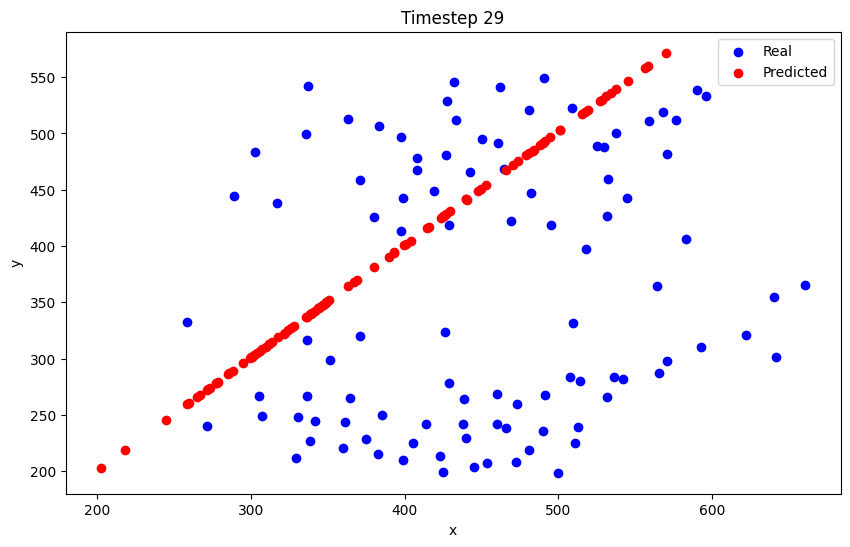

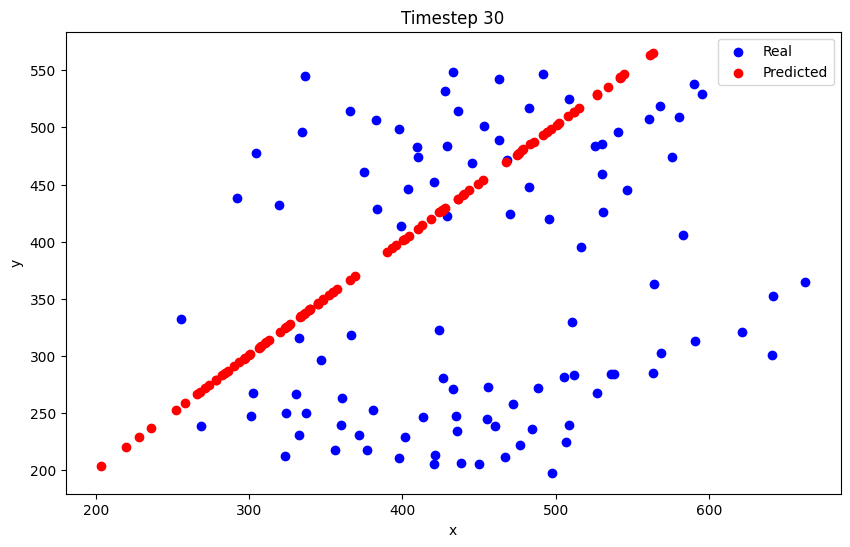

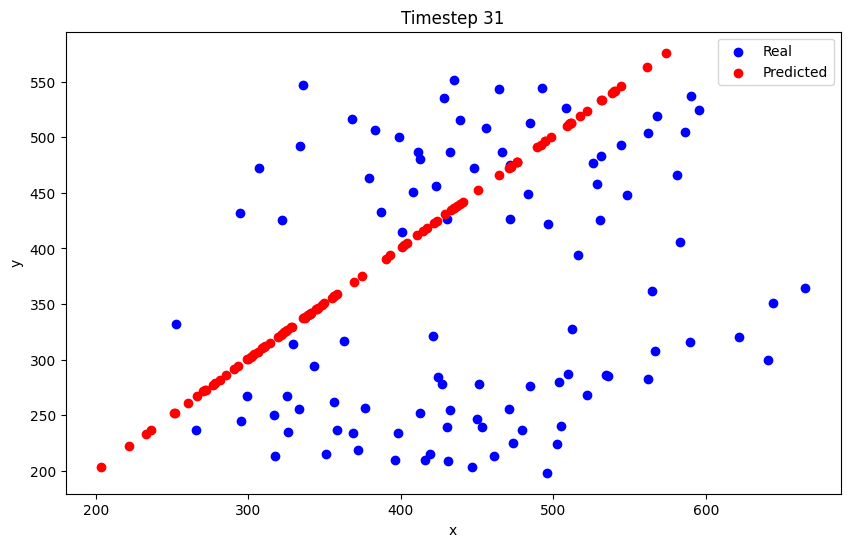

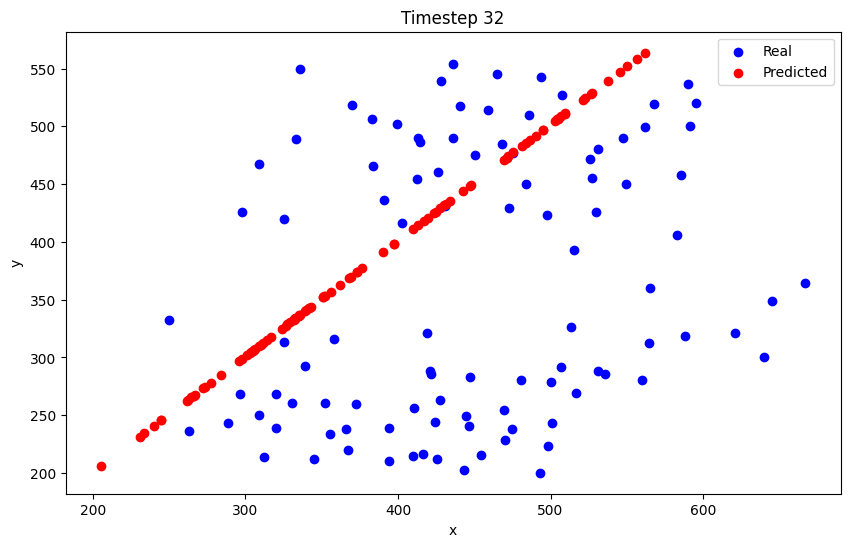

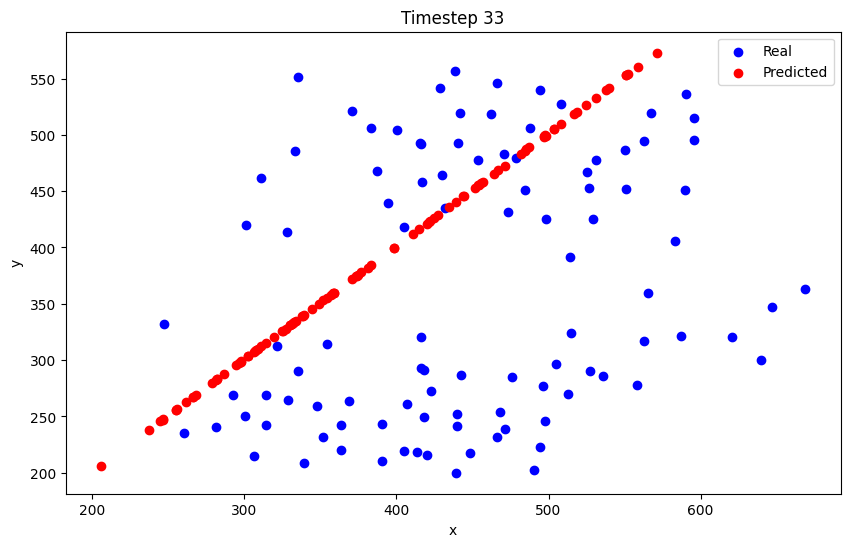

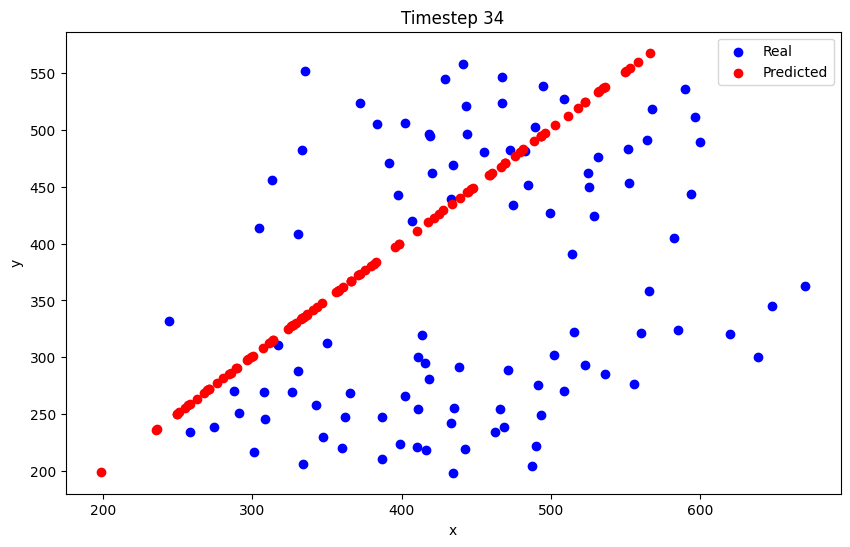

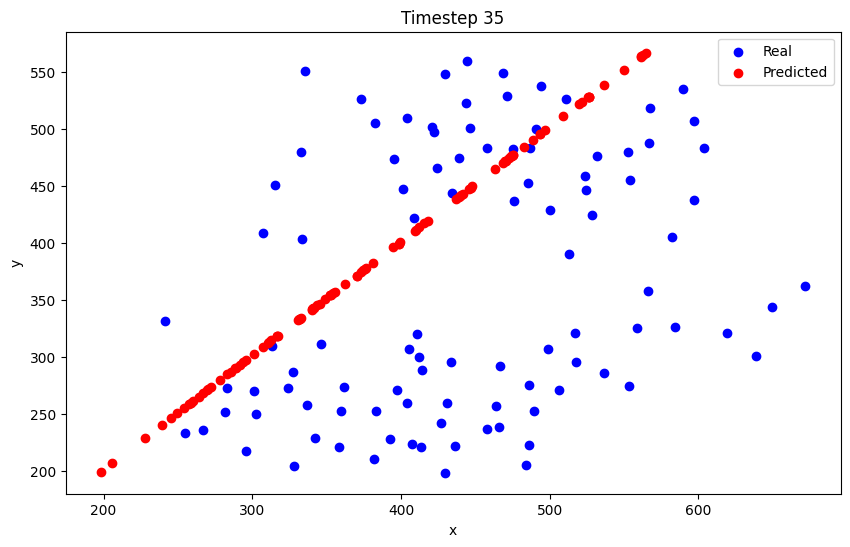

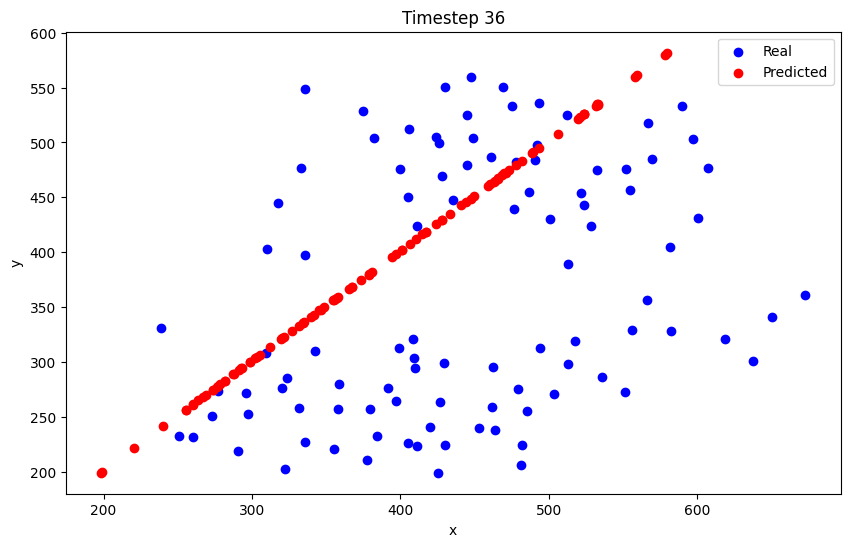

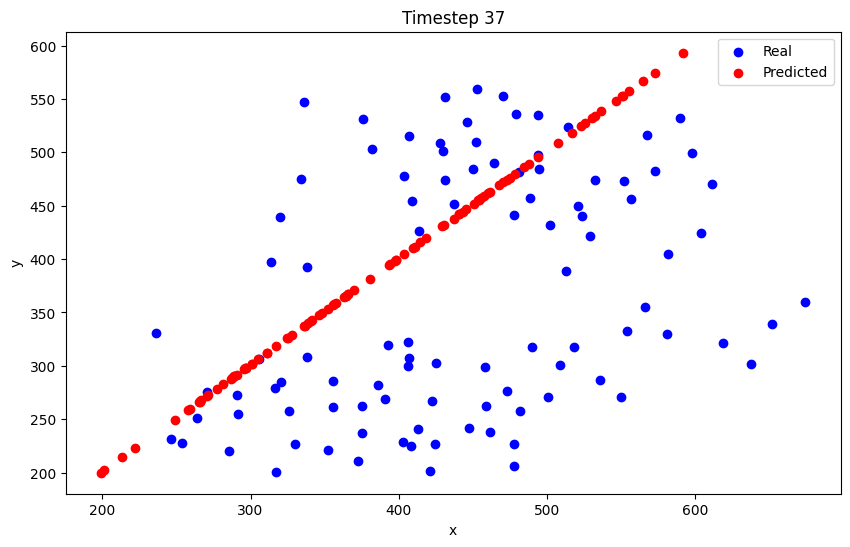

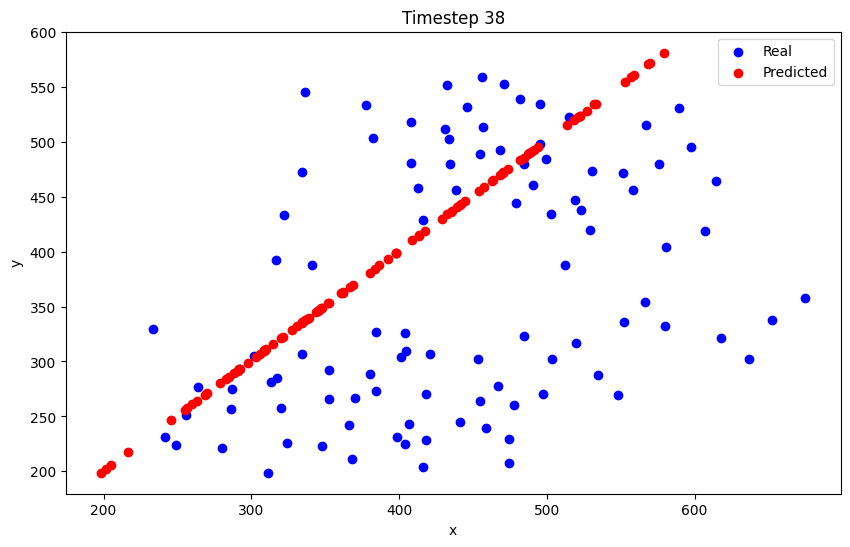

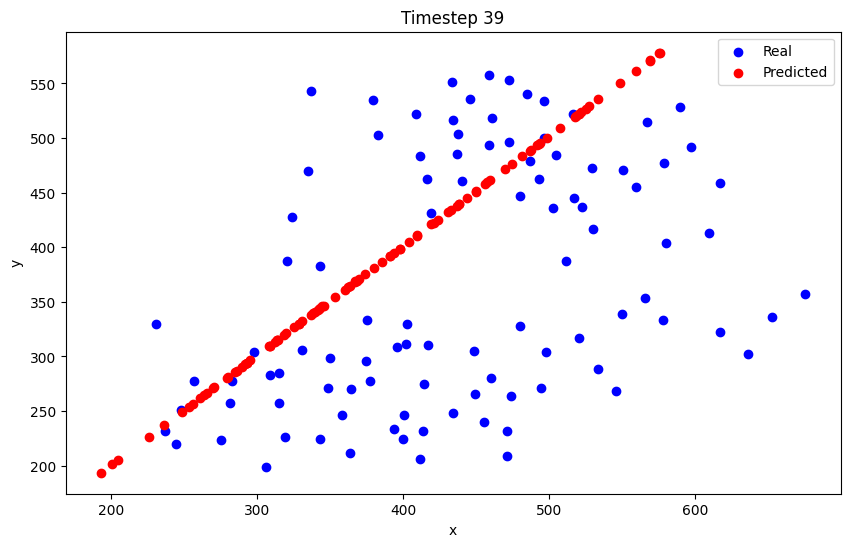

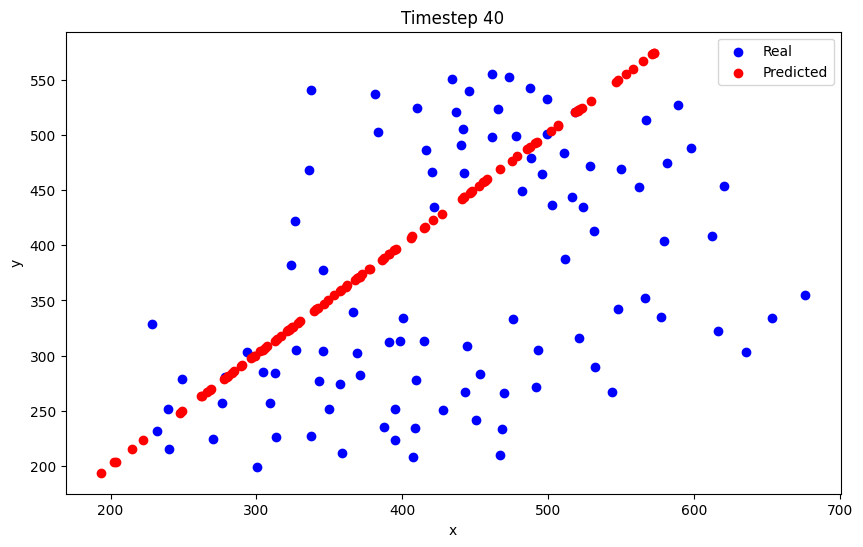

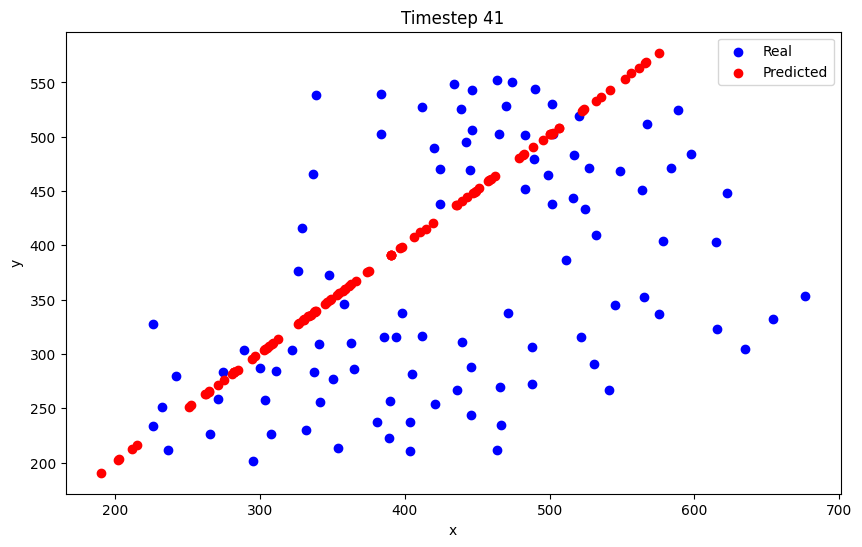

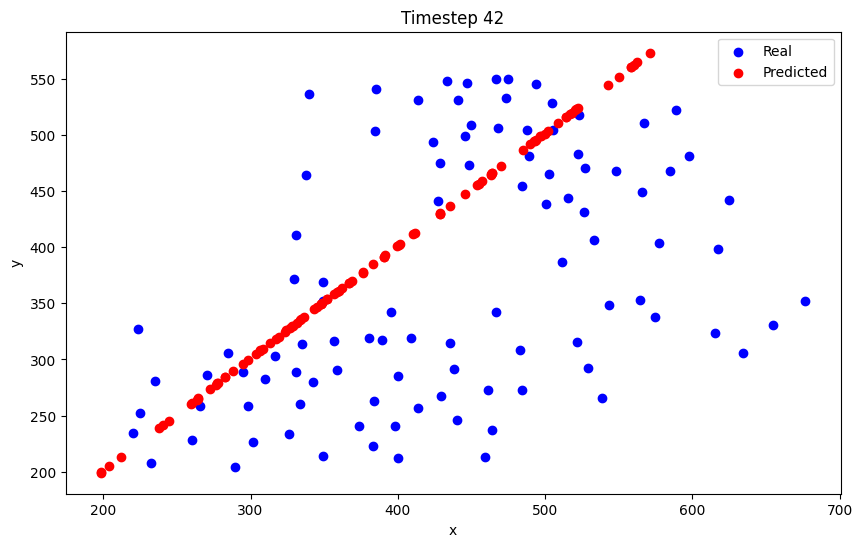

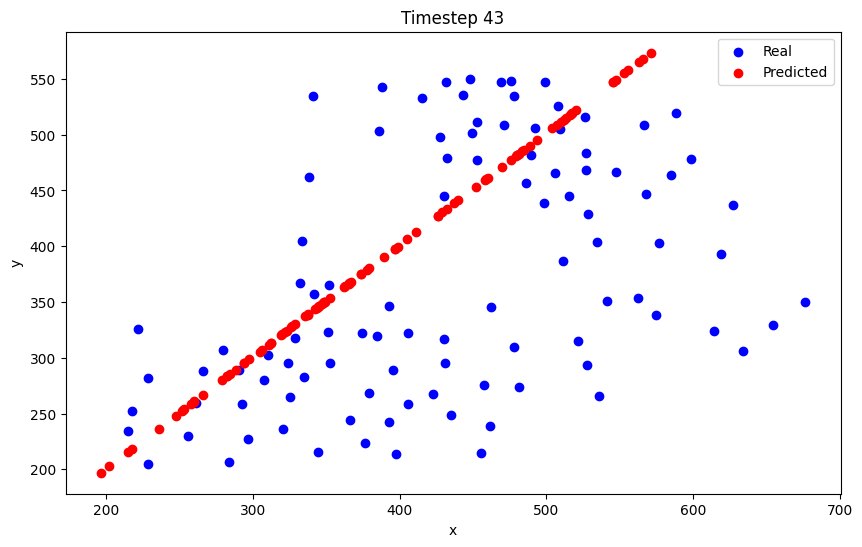

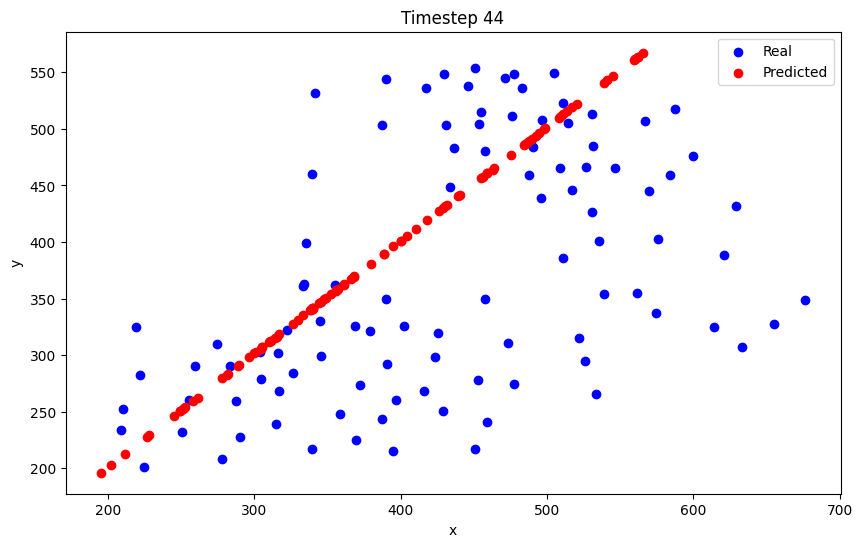

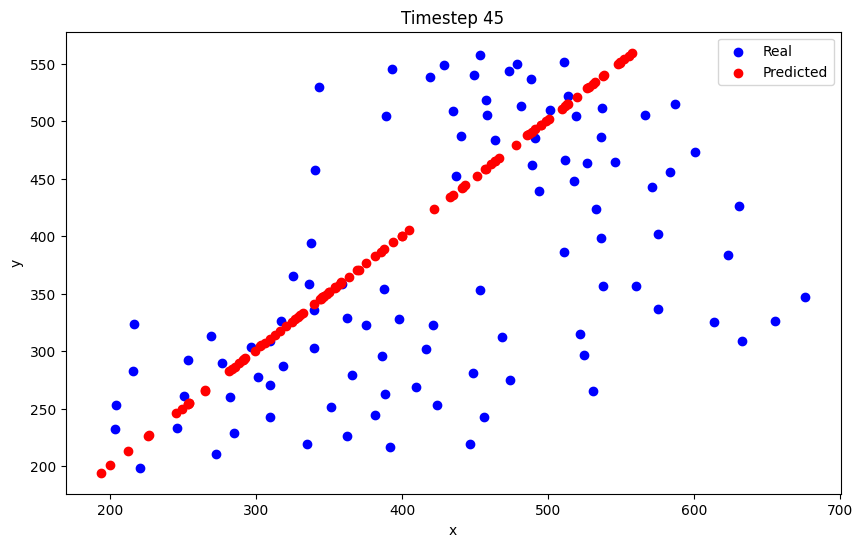

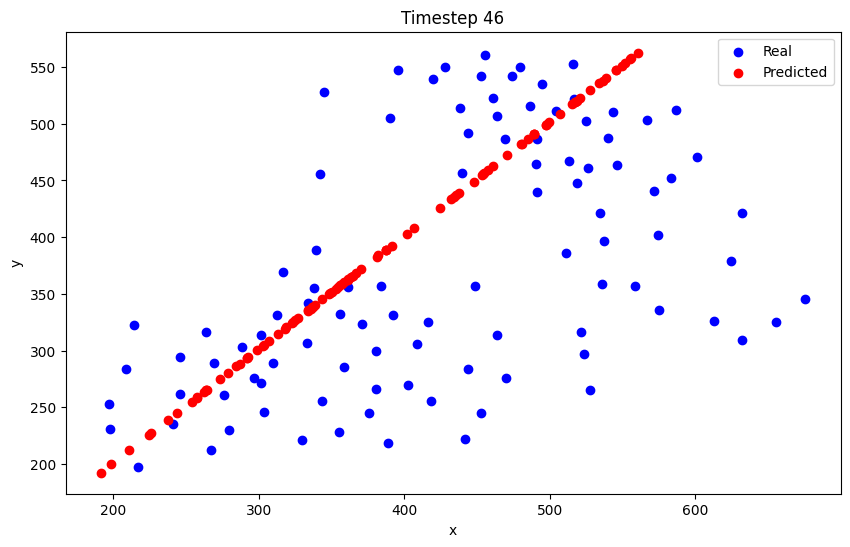

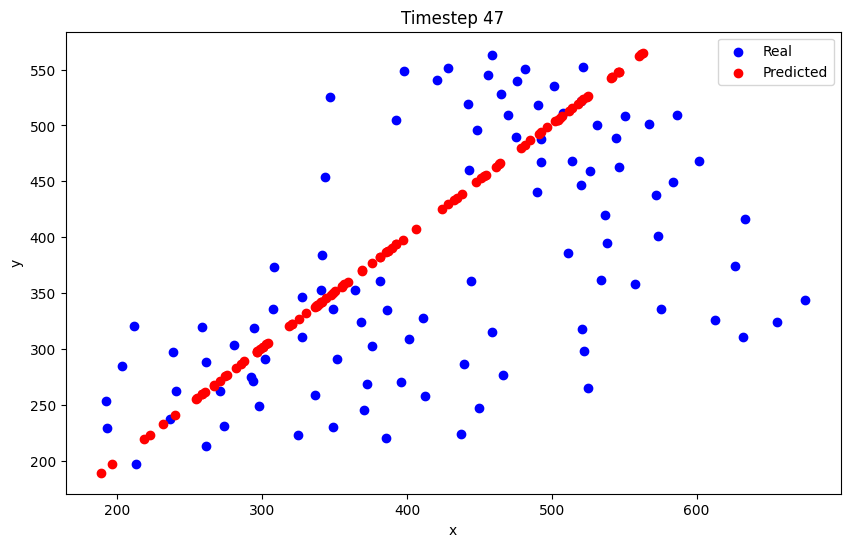

In [2]:
import math
import random
import pygame
import sys
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
import matplotlib.pyplot as plt

# Size of canvas
width = 1000
height = 750
numBoids = 100
visualRange = 75
boids = []

def initBoids():
    global boids
    boids = []
    for i in range(numBoids):
        boids.append({
            'x': random.random() * width,
            'y': random.random() * height,
            'dx': random.random() * 10 - 5,
            'dy': random.random() * 10 - 5,
            'history': [],
        })

def distance(boid1, boid2):
    return math.sqrt((boid1['x'] - boid2['x'])**2 + (boid1['y'] - boid2['y'])**2)

def sizeCanvas():
    global width, height
    size = (width, height)
    return pygame.display.set_mode(size)

def keepWithinBounds(boid):
    margin = 200
    turnFactor = 1
    if boid['x'] < margin:
        boid['dx'] += turnFactor
    if boid['x'] > width - margin:
        boid['dx'] -= turnFactor
    if boid['y'] < margin:
        boid['dy'] += turnFactor
    if boid['y'] > height - margin:
        boid['dy'] -= turnFactor

def flyTowardsCenter(boid):
    centeringFactor = 0.005
    centerX = 0
    centerY = 0
    numNeighbors = 0
    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            centerX += otherBoid['x']
            centerY += otherBoid['y']
            numNeighbors += 1
    if numNeighbors:
        centerX /= numNeighbors
        centerY /= numNeighbors
        boid['dx'] += (centerX - boid['x']) * centeringFactor
        boid['dy'] += (centerY - boid['y']) * centeringFactor

def avoidOthers(boid):
    minDistance = 20
    avoidFactor = 0.05
    moveX = 0
    moveY = 0
    for otherBoid in boids:
        if otherBoid != boid:
            if distance(boid, otherBoid) < minDistance:
                moveX += boid['x'] - otherBoid['x']
                moveY += boid['y'] - otherBoid['y']
    boid['dx'] += moveX * avoidFactor
    boid['dy'] += moveY * avoidFactor

def matchVelocity(boid):
    matchingFactor = 0.05
    avgDX = 0
    avgDY = 0
    numNeighbors = 0
    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            avgDX += otherBoid['dx']
            avgDY += otherBoid['dy']
            numNeighbors += 1
    if numNeighbors:
        avgDX /= numNeighbors
        avgDY /= numNeighbors
        boid['dx'] += (avgDX - boid['dx']) * matchingFactor
        boid['dy'] += (avgDY - boid['dy']) * matchingFactor

def limitSpeed(boid):
    speedLimit = 15
    speed = math.sqrt(boid['dx']**2 + boid['dy']**2)
    if speed > speedLimit:
        boid['dx'] = (boid['dx'] / speed) * speedLimit
        boid['dy'] = (boid['dy'] / speed) * speedLimit

def drawBoid(screen, boid):
    angle = math.atan2(boid['dy'], boid['dx'])
    boid_surface = pygame.Surface((30, 10), pygame.SRCALPHA)
    pygame.draw.polygon(boid_surface, (85, 140, 244), [
        (0, 0), (0, 10), (-15, 5)
    ])
    rotated_boid = pygame.transform.rotate(boid_surface, math.degrees(angle))
    rotated_rect = rotated_boid.get_rect(center=(boid['x'], boid['y']))
    screen.blit(rotated_boid, rotated_rect)

    if DRAW_TRAIL:
        for point in boid['history']:
            pygame.draw.circle(screen, (85, 140, 244, 102), (int(point[0]), int(point[1])), 1)

def animationLoop():
    global boids
    for boid in boids:
        flyTowardsCenter(boid)
        avoidOthers(boid)
        matchVelocity(boid)
        limitSpeed(boid)
        keepWithinBounds(boid)

        boid['x'] += boid['dx']
        boid['y'] += boid['dy']
        boid['history'].append((boid['x'], boid['y']))
        boid['history'] = boid['history'][-50:]

    screen.fill((255, 255, 255))
    for boid in boids:
        drawBoid(screen, boid)

    pygame.display.flip()
    pygame.time.Clock().tick(60)

# Save simulation data
pygame.init()
screen = sizeCanvas()
DRAW_TRAIL = False
num_time_steps = 100
num_sims = 10

for k in range(num_sims):
    initBoids()
    for _ in range(num_time_steps):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
        animationLoop()

    time_list = []
    for i in range(len(boids[0]["history"])):
        boid_dict = {}
        if i == 0:
            continue
        else:
            for j in range(len(boids)):
                dic = {}
                dic['x'] = boids[j]['history'][i][0]
                dic['y'] = boids[j]['history'][i][1]
                dic['dx'] = boids[j]['history'][i][0] - boids[j]['history'][i-1][0]
                dic['dy'] = boids[j]['history'][i][1] - boids[j]['history'][i-1][1]
                boid_dict[f'boid{j}'] = dic

        time_list.append(boid_dict)

    with open(f"../data/myjson/mydata{k}.json", "w") as final:
        json.dump(time_list, final)

pygame.quit()

# Load and preprocess data
def load_and_preprocess_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    num_timesteps = len(data)
    num_boids = len(data[0])

    features_list = []
    adjacency_matrices = []

    for t in range(num_timesteps):
        features = np.zeros((num_boids, 4))
        for i in range(num_boids):
            boid_data = data[t][f'boid{i}']
            features[i, 0] = boid_data['x']
            features[i, 1] = boid_data['y']
            features[i, 2] = boid_data['dx']
            features[i, 3] = boid_data['dy']
        
        adjacency_matrix = np.zeros((num_boids, num_boids))
        for i in range(num_boids):
            for j in range(num_boids):
                if i != j and distance(data[t][f'boid{i}'], data[t][f'boid{j}']) < visualRange:
                    adjacency_matrix[i, j] = 1
        
        features_list.append(torch.tensor(features, dtype=torch.float))
        adjacency_matrices.append(torch.tensor(adjacency_matrix, dtype=torch.float))
    
    return features_list, adjacency_matrices

features_list, adjacency_matrices = load_and_preprocess_data("../data/myjson/mydata1.json")

print("Features shape:", features_list[0].shape)
print("Adjacency matrix shape:", adjacency_matrices[0].shape)

# Define GRNN Generator
class GRNNGenerator(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GRNNGenerator, self).__init__()
        self.encoder = GCNConv(in_channels, hidden_channels)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )
    
    def forward(self, features, edge_index):
        x = self.encoder(features, edge_index)
        x = F.relu(x)
        x = self.decoder(x)
        return x

# Initialize the generator
generator = GRNNGenerator(in_channels=4, hidden_channels=16, out_channels=4)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize the discriminator
discriminator = Discriminator(input_dim=4, hidden_dim=16)

# Hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 0.0002

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(num_epochs):
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        next_real_features = features_list[t + 1]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()

        # Train Discriminator
        d_optimizer.zero_grad()
        
        real_labels = torch.ones(next_real_features.size(0), 1)
        fake_labels = torch.zeros(next_real_features.size(0), 1)
        
        real_output = discriminator(next_real_features)
        d_loss_real = criterion(real_output, real_labels)
        
        fake_features = generator(real_features, edge_index)
        fake_output = discriminator(fake_features.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        
        fake_output = discriminator(fake_features)
        g_loss = criterion(fake_output, real_labels)
        
        g_loss.backward()
        g_optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{t+1}/{len(features_list)-1}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Plotting generator predictions
with torch.no_grad():
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()
        predicted_features = generator(real_features, edge_index).numpy()
        
        plt.figure(figsize=(10, 6))
        plt.scatter(real_features[:, 0], real_features[:, 1], c='blue', label='Real')
        plt.scatter(predicted_features[:, 0], predicted_features[:, 1], c='red', label='Predicted')
        plt.legend()
        plt.title(f'Timestep {t}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()


In [104]:
import math
import random
import pygame
import sys
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

# Size of canvas
width, height = 1000, 750
boidneigbor, numBoids, visualRange = 3, 100, 75

boids = []

def initBoids():
    global boids
    boids = []
    for i in range(numBoids):
        boids.append({
            'x': random.random() * width,
            'y': random.random() * height,
            'dx': random.random() * 10 - 5,
            'dy': random.random() * 10 - 5,
            'history': [],
        })

def distance(boid1, boid2):
    return math.sqrt((boid1['x'] - boid2['x'])**2 + (boid1['y'] - boid2['y'])**2)

def sizeCanvas():
    global width, height
    size = (width, height)
    return pygame.display.set_mode(size)

def flyTowardsCenter(boid):
    centeringFactor = 0.005
    centerX, centerY, numNeighbors = 0, 0, 0

    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            centerX += otherBoid['x']
            centerY += otherBoid['y']
            numNeighbors += 1

    if numNeighbors:
        centerX /= numNeighbors
        centerY /= numNeighbors
        boid['dx'] += (centerX - boid['x']) * centeringFactor
        boid['dy'] += (centerY - boid['y']) * centeringFactor

def avoidOthers(boid):
    minDistance = 20
    avoidFactor = 0.05
    moveX, moveY = 0, 0

    for otherBoid in boids:
        if otherBoid != boid and distance(boid, otherBoid) < minDistance:
            moveX += boid['x'] - otherBoid['x']
            moveY += boid['y'] - otherBoid['y']

    boid['dx'] += moveX * avoidFactor
    boid['dy'] += moveY * avoidFactor

def matchVelocity(boid):
    matchingFactor = 0.05
    avgDX, avgDY, numNeighbors = 0, 0, 0

    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            avgDX += otherBoid['dx']
            avgDY += otherBoid['dy']
            numNeighbors += 1

    if numNeighbors:
        avgDX /= numNeighbors
        avgDY /= numNeighbors
        boid['dx'] += (avgDX - boid['dx']) * matchingFactor
        boid['dy'] += (avgDY - boid['dy']) * matchingFactor

def limitSpeed(boid):
    speedLimit = 15
    speed = math.sqrt(boid['dx']**2 + boid['dy']**2)
    if speed > speedLimit:
        boid['dx'] = (boid['dx'] / speed) * speedLimit
        boid['dy'] = (boid['dy'] / speed) * speedLimit

def drawBoid(screen, boid):
    angle = math.atan2(boid['dy'], boid['dx'])
    boid_surface = pygame.Surface((30, 10), pygame.SRCALPHA)
    pygame.draw.polygon(boid_surface, (85, 140, 244), [(0, 0), (0, 10), (-15, 5)])
    rotated_boid = pygame.transform.rotate(boid_surface, math.degrees(angle))
    rotated_rect = rotated_boid.get_rect(center=(boid['x'], boid['y']))
    screen.blit(rotated_boid, rotated_rect)

    if DRAW_TRAIL:
        for point in boid['history']:
            pygame.draw.circle(screen, (85, 140, 244, 102), (int(point[0]), int(point[1])), 1)

# Main animation loop
def animationLoop():
    global boids
    for boid in boids:
        flyTowardsCenter(boid)
        avoidOthers(boid)
        matchVelocity(boid)
        limitSpeed(boid)

        boid['x'] += boid['dx']
        boid['y'] += boid['dy']
        boid['history'].append((boid['x'], boid['y']))
        boid['history'] = boid['history'][-50:]

    screen.fill((255, 255, 255))
    for boid in boids:
        drawBoid(screen, boid)

    pygame.display.flip()
    pygame.time.Clock().tick(60)

pygame.init()
screen = sizeCanvas()
DRAW_TRAIL = False
num_time_steps = 100
num_sims = 10
velocities, positions = [], []

for k in range(num_sims):
    initBoids()
    for _ in range(num_time_steps):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
        animationLoop()

    time_list = []

    for i in range(len(boids[1]["history"])):
        boid_dict = {}
        if i == 0:
            continue
        else:
            for j in range(len(boids)):
                dic = {}
                dic['x'] = boids[j]['history'][i][0]
                dic['y'] = boids[j]['history'][i][1]
                dic['dx'] = boids[j]['history'][i][0] - boids[j]['history'][i-1][0]
                dic['dy'] = boids[j]['history'][i][1] - boids[j]['history'][i-1][1]
                boid_dict[f'boid{j}'] = dic
        time_list.append(boid_dict)

    with open(f"../data/myjson/mydata{k}.json", "w") as final:
        json.dump(time_list, final)

# Load data for training (example for one simulation)
with open(f"../data/myjson/mydata0.json", "r") as f:
    time_list = json.load(f)

# Convert data to graph format
def create_graph_data(time_list):
    node_features = []
    edge_index = [[], []]
    for time_step in time_list:
        for boid_id, boid_data in time_step.items():
            node_features.append([boid_data['x'], boid_data['y'], boid_data['dx'], boid_data['dy']])
            for other_boid_id, other_boid_data in time_step.items():
                if boid_id != other_boid_id:
                    edge_index[0].append(int(boid_id.replace('boid', '')))
                    edge_index[1].append(int(other_boid_id.replace('boid', '')))
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    return Data(x=node_features, edge_index=edge_index)

data = create_graph_data(time_list)

# Define the encoder, decoder, and GRNN models
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(in_channels, hidden_channels)

    def forward(self, x):
        return torch.relu(self.linear(x))

class Decoder(nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        return self.linear(x)

class RecurrentGNN(MessagePassing):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(RecurrentGNN, self).__init__(aggr='add')
        self.gru = nn.GRUCell(hidden_channels, hidden_channels)
        self.encoder = Encoder(in_channels, hidden_channels)
        self.decoder = Decoder(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.encoder(x)
        out = x
        for _ in range(3):  # Number of recurrent steps
            out = self.propagate(edge_index, x=out)
        out = self.decoder(out)
        return out

    def message(self, x_j):
        return x_j

    def update(self, aggr_out, x):
        return self.gru(aggr_out, x)

# Initialize the model, optimizer, and loss function
model = RecurrentGNN(in_channels=4, hidden_channels=8, out_channels=4)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        next_real_features = features_list[t + 1]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()

        # Train Discriminator
        d_optimizer.zero_grad()
        
        real_labels = torch.ones(next_real_features.size(0), 1)
        fake_labels = torch.zeros(next_real_features.size(0), 1)
        
        real_output = discriminator(next_real_features)
        d_loss_real = criterion(real_output, real_labels)
        
        fake_features = generator(real_features, edge_index)
        fake_output = discriminator(fake_features.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        
        fake_output = discriminator(fake_features)
        g_loss = criterion(fake_output, real_labels)
        
        g_loss.backward()
        g_optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{t+1}/{len(features_list)-1}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Plotting generator predictions
with torch.no_grad():
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()
        predicted_features = generator(real_features, edge_index).numpy()
        
        plt.figure(figsize=(10, 6))
        plt.scatter(real_features[:, 0], real_features[:, 1], c='blue', label='Real')
        plt.scatter(predicted_features[:, 0], predicted_features[:, 1], c='red', label='Predicted')
        plt.legend()
        plt.title(f'Timestep {t}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()



TypeError: GGNN.forward() missing 1 required positional argument: 'A'

: 

array([[ 5.04015839e+02,  2.23763031e+02,  5.61255217e-02,
         6.27523470e+00],
       [ 7.84666992e+02,  3.45088898e+02,  5.28552890e-01,
         8.63259506e+00],
       [ 4.42043732e+02,  1.94988998e+02,  1.63822055e-01,
         5.10825300e+00],
       [ 6.99846802e+02,  3.13071228e+02, -1.68308377e-01,
         9.41958427e+00],
       [ 6.04245972e+02,  2.69398010e+02, -7.68548250e-02,
         7.83913851e+00],
       [ 7.31971313e+02,  3.27205994e+02, -1.48243070e-01,
         9.78993225e+00],
       [ 5.47905273e+02,  2.41249527e+02,  3.98361087e-01,
         6.18644571e+00],
       [ 6.28365601e+02,  2.77456512e+02,  2.48546481e-01,
         7.39802885e+00],
       [ 7.17056519e+02,  3.16207916e+02,  3.72089267e-01,
         8.28936386e+00],
       [ 5.24315247e+02,  2.32465439e+02,  9.83809233e-02,
         6.44480753e+00],
       [ 6.42170715e+02,  2.82665558e+02,  3.54961276e-01,
         7.30648088e+00],
       [ 6.27588379e+02,  2.76878815e+02,  2.80872226e-01,
      